<a href="https://colab.research.google.com/github/MatiasNazareth1993-coder/Virtual-cell/blob/main/Virtual_Cell_Colab_ready_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Example high-level module structure

class SyntheticTelomere:
    def __init__(self, sequence, resistance_factor):
        self.sequence = sequence
        self.resistance_factor = resistance_factor
        self.length = len(sequence)

    def degrade(self, oxidative_stress):
        loss = oxidative_stress / self.resistance_factor
        self.length -= loss

    def repair(self, telomerase_activity):
        self.length += telomerase_activity * 0.8  # efficiency constant


class TelomeraseRegulator:
    def __init__(self, model):
        self.model = model  # RL model or neural controller

    def regulate(self, telomere_length, stress):
        return self.model.predict([telomere_length, stress])


class PhagocytosisEngine:
    def __init__(self, efficiency=0.9):
        self.efficiency = efficiency

    def clean(self, debris_concentration):
        return debris_concentration * (1 - self.efficiency)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentiall

Using cpu device


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------
| time/              |      |
|    fps             | 1476 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1024         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0049040015 |
|    clip_fraction        | 0.045        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.000502     |
|    learning_rate        | 0.0003       |
|    loss                 | 10.5         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00242     |
|    std                  | 0.991        |
|    value_loss           | 77.7         |
----------------

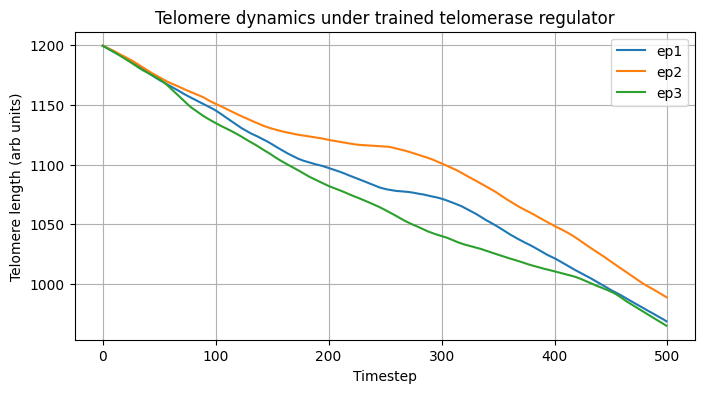

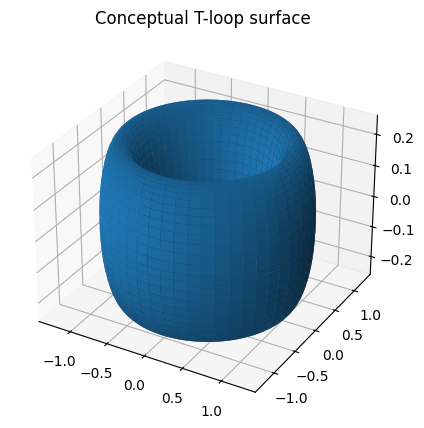

Saved model as telomerase_regulator_ppo.zip


In [ ]:
# IVCSF Colab-ready simulation notebook (single-file .py with cell markers)
# Purpose: Provide a runnable simulation environment for a virtual cell with
# synthetic telomere dynamics, a telomerase regulator (RL controller using
# stable-baselines3 PPO), and a phagocytosis/environment module. This file is
# formatted with cell markers so you can copy it into a Colab notebook or
# upload it as a .py and open with "Open in Colab".

# %% [markdown]
# # Immortal Virtual Cell Simulation Framework (Colab-ready)
#
# **Overview**: This notebook defines a lightweight, extensible simulation of
# telomere dynamics and an RL-based telomerase regulator. It's intentionally
# modular so you can expand biological detail, swap RL algorithms, or plug in
# real sensor data from organ-on-a-chip experiments.
#
# **Quick usage**:
# 1. Upload this file to Colab and run the cells in order.
# 2. Install required packages when prompted.
# 3. Train the RL agent (PPO) for a few thousand timesteps to see basic
#    behavior. The environment is small and designed for quick iteration.

# %%
# Install dependencies (run once in Colab)
!pip install --quiet stable-baselines3[extra] gym numpy matplotlib tqdm shimmy>=0.2.1

# %%
# Imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import gym
from gym import spaces

# RL imports
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# %% [markdown]
# ## 1) Core simulation classes
# We'll implement simplified but extensible models for telomeres, telomerase
# regulation (controller uses RL), and a phagocytosis engine.

# %%
class SyntheticTelomere:
    """Represents a synthetic telomere with length, sequence-derived stability,
    and basic dynamics for degradation/repair.
    """
    def __init__(self, base_length=1000.0, resistance_factor=2.0, sequence_score=1.0):
        # base_length: units of 'bp-equivalent' for simulation convenience
        self.length = float(base_length)
        # resistance_factor reduces degradation per timestep
        self.resistance_factor = float(resistance_factor)
        # sequence_score is an abstracted measure of T-loop folding/stability
        self.sequence_score = float(sequence_score)

    def degrade(self, oxidative_stress=1.0):
        # simple degradation model scaled by oxidative stress and inverse resistance
        loss = (oxidative_stress / self.resistance_factor) * (1.0 / max(0.1, self.sequence_score))
        self.length = max(0.0, self.length - loss)
        return loss

    def repair(self, telomerase_activity=0.0, efficiency=0.8):
        # telomerase_activity is agent output (≥0). efficiency scales conversion to bp
        gain = telomerase_activity * efficiency
        # T-loop binding and sequence can modulate effective gain
        gain *= (0.9 + 0.1 * self.sequence_score)
        self.length += gain
        return gain

    def mutation_risk(self):
        # heuristic: very long telomeres + abnormal fluctuations increase risk
        risk = max(0.0, math.exp((self.length - 3000.0) / 2000.0) - 1.0)
        return risk

# %%
class PhagocytosisEngine:
    """Abstract model for debris clearance in the microenvironment."""
    def __init__(self, efficiency=0.7):
        self.efficiency = float(efficiency)

    def clear(self, debris_level):
        # Removes a fraction of debris each timestep
        removed = debris_level * self.efficiency
        remaining = max(0.0, debris_level - removed)
        return remaining, removed

# %%
class TelomeraseRegulator:
    """A light wrapper for an RL agent; we'll plug in a trained model later."""
    def __init__(self, model=None):
        self.model = model

    def act(self, obs):
        # if model present, use it; else return a baseline action
        if self.model is None:
            # baseline: keep telomerase activity proportional to inverse of length
            L = obs[0]
            desired = max(0.0, 1.0 * (1.0 - L / 2000.0))
            return desired
        action, _ = self.model.predict(obs, deterministic=True)
        # action is returned as a 1D array or scalar depending on action space
        if isinstance(action, (list, tuple, np.ndarray)):
            return float(action[0])
        return float(action)

# %% [markdown]
# ## 2) Gym environment
# We'll define a compact gym.Env that exposes the essential state variables
# to an RL agent. The state vector contains: [telomere_length, oxidative_stress,
# debris_level, cell_health]. The agent outputs a scalar controlling telomerase
# activity in range [0, max_act].

# %%
class VirtualCellEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, max_telomerase_action=10.0, seed=None):
        super().__init__()
        self.rng = np.random.RandomState(seed)
        # Observation: telomere length, oxidative stress, debris, cell health
        low = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high = np.array([10000.0, 10.0, 100.0, 1.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        # Action: telomerase activity scalar
        self.action_space = spaces.Box(low=0.0, high=max_telomerase_action, shape=(1,), dtype=np.float32)

        # Internal components
        self.telomere = SyntheticTelomere(base_length=1200.0, resistance_factor=2.0, sequence_score=1.0)
        self.phago = PhagocytosisEngine(efficiency=0.7)

        # state
        self.debris = 5.0
        self.oxidative_stress = 1.0
        self.cell_health = 1.0
        self.max_telomerase_action = float(max_telomerase_action)
        self.step_count = 0
        self.max_steps = 500

    def reset(self):
        self.telomere = SyntheticTelomere(base_length=1200.0, resistance_factor=2.0, sequence_score=1.0)
        self.debris = 5.0
        self.oxidative_stress = 1.0
        self.cell_health = 1.0
        self.step_count = 0
        obs = np.array([self.telomere.length, self.oxidative_stress, self.debris, self.cell_health], dtype=np.float32)
        return obs

    def step(self, action):
        # Ensure action is a scalar before clipping
        act = float(np.clip(action[0], 0.0, self.max_telomerase_action))
        # environment stochasticity
        self.oxidative_stress = max(0.1, self.oxidative_stress + self.rng.normal(0, 0.05))
        # degrade telomere
        degraded = self.telomere.degrade(oxidative_stress=self.oxidative_stress)
        # repair via telomerase
        repaired = self.telomere.repair(telomerase_activity=act, efficiency=0.8)
        # phagocytosis
        self.debris, removed = self.phago.clear(self.debris + self.rng.normal(0, 0.5))
        # cell health heuristics
        # health reduces with debris and high oxidative stress; long telomere beyond a bound can raise mutation risk
        risk = self.telomere.mutation_risk()
        self.cell_health = float(np.clip(1.0 - 0.1 * self.oxidative_stress - 0.01 * self.debris - 0.1 * risk, 0.0, 1.0))

        # reward: encourage stable division (proxy: maintain telomere in target window and keep cell_health high)
        target_min, target_max = 800.0, 2000.0
        in_window = 1.0 if (target_min <= self.telomere.length <= target_max) else 0.0
        reward = in_window * (0.5 + 0.5 * self.cell_health) - 0.2 * risk - 0.01 * self.debris

        self.step_count += 1
        done = False
        # episode termination conditions
        if self.cell_health <= 0.05:
            done = True
            reward -= 1.0  # strong penalty for collapse
        if self.step_count >= self.max_steps:
            done = True

        obs = np.array([self.telomere.length, self.oxidative_stress, self.debris, self.cell_health], dtype=np.float32)
        info = {
            'degraded': degraded,
            'repaired': repaired,
            'removed_debris': removed,
            'mutation_risk': risk
        }
        return obs, float(reward), done, info

    def render(self, mode='human'):
        print(f"Step {self.step_count}: Telomere={self.telomere.length:.1f}, OxStress={self.oxidative_stress:.2f}, Debris={self.debris:.2f}, Health={self.cell_health:.2f}")

# %% [markdown]
# ## 3) Training utilities and callback for logging

# %%
class TrainLogger(BaseCallback):
    """Custom callback to log per-episode metrics."""
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []

    def _on_step(self) -> bool:
        return True

# %% [markdown]
# ## 4) Train a PPO agent quickly and visualize results

# %%
def train_agent(total_timesteps=20000, seed=42):
    env = DummyVecEnv([lambda: VirtualCellEnv(seed=seed)])
    model = PPO('MlpPolicy', env, verbose=1, seed=seed)
    callback = TrainLogger()
    model.learn(total_timesteps=total_timesteps, callback=callback)
    return model

# %%
# Quick train (you can increase timesteps for stronger policies)
model = train_agent(total_timesteps=15000)

# %% [markdown]
# ## 5) Evaluate the trained agent and plot telomere dynamics

# %%
def evaluate_model(model, episodes=5):
    env = VirtualCellEnv()
    trajs = []
    for ep in range(episodes):
        obs = env.reset()
        done = False
        history = {'telomere': [], 'oxidative_stress': [], 'debris': [], 'health': [], 'reward': []}
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            history['telomere'].append(env.telomere.length)
            history['oxidative_stress'].append(env.oxidative_stress)
            history['debris'].append(env.debris)
            history['health'].append(env.cell_health)
            history['reward'].append(reward)
        trajs.append(history)
    return trajs

trajs = evaluate_model(model, episodes=3)

# %%
# Plot telomere length over time for each episode
plt.figure(figsize=(8,4))
for i, h in enumerate(trajs):
    plt.plot(h['telomere'], label=f'ep{i+1}')
plt.xlabel('Timestep')
plt.ylabel('Telomere length (arb units)')
plt.title('Telomere dynamics under trained telomerase regulator')
plt.legend()
plt.grid(True)
plt.show()

# %% [markdown]
# ## 6) 3D mock-up visualization of a T-loop
# This is a conceptual visualization — in-depth molecular modeling should use PyMOL,
# MD packages, or dedicated structural biology tools. Here we draw a simple torus-like loop
# to help reason about loop stability changes.

# %%
from mpl_toolkits.mplot3d import Axes3D

def plot_tloop(radius_major=1.0, radius_minor=0.3, n_points=200):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2*np.pi, n_points)
    v = np.linspace(0, 2*np.pi, n_points)
    U, V = np.meshgrid(u, v)
    X = (radius_major + radius_minor*np.cos(V)) * np.cos(U)
    Y = (radius_major + radius_minor*np.cos(V)) * np.sin(U)
    Z = radius_minor * np.sin(V)
    ax.plot_surface(X, Y, Z, rstride=4, cstride=4, linewidth=0, antialiased=True)
    ax.set_title('Conceptual T-loop surface')
    plt.show()

plot_tloop(radius_major=1.0, radius_minor=0.25)

# %% [markdown]
# ## 7) Save model & next steps
# Save the trained model to disk (Colab: files.download can be used to fetch it)

# %%
model.save('telomerase_regulator_ppo')
print('Saved model as telomerase_regulator_ppo.zip')

# %% [markdown]
# ## Extensions and notes
# * Replace the `SyntheticTelomere` degradation/repair functions with m

In [ ]:
!pip install --quiet shimmy>=0.2.1

The error `ImportError: Missing shimmy installation` in cell `vfHX4N9uE_Ac` occurs because recent versions of `stable-baselines3` (used for reinforcement learning) now rely on the `shimmy` library to ensure compatibility with environments created using the older OpenAI Gym library.

To fix this, we need to install `shimmy`. The code cell I just added above will do that. After the installation completes, you can re-run the code cell that produced the error.

In [ ]:
# IVCSF Colab-ready simulation notebook (extended biological detail)
# Purpose: Provide a runnable simulation environment for a virtual cell with
# synthetic telomere dynamics, a mechanistic telomerase model, sequence-level
# effects on T-loop stability, explicit mutation accumulation and repair
# pathways, an RL-based telomerase regulator (PPO), and an environment/ phagocytosis module.
#
# Notes:
# - This file is formatted with cell markers so you can copy it into Colab
#   or upload it as a .py and open with "Open in Colab".
# - The biological models are simplified abstractions intended for simulation
#   and algorithmic exploration — not for immediate wet-lab translation.

# %% [markdown]
# # Immortal Virtual Cell Simulation Framework (Extended Biological Detail)
#
# **What's new in this extended version**
# - Sequence-aware telomere model with motif scoring and simplified folding energy
# - Telomerase kinetics modeled with Michaelis-Menten-like dynamics and explicit
#   binding/unbinding (on/off rates)
# - DNA damage / repair module (HR vs NHEJ heuristic) and mutation accumulation
# - Cell cycle checkpoint (p53-like) that imposes senescence/apoptosis risk
# - Mutation-driven oncogenic transformation probability
# - Enhanced reward shaping to penalize mutation accumulation and checkpoint events

# %%
# Install dependencies (run once in Colab)
!pip install --quiet stable-baselines3[extra] gym numpy matplotlib tqdm

# %%
# Imports
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import gym
from gym import spaces

# RL imports
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# %% [markdown]
# ## 1) Mechanistic biological components
# The following classes add more biological realism while remaining computationally
# tractable for RL experiments.

# %%
class SequenceTelomere:
    """Sequence-aware telomere model.
    - Stores a simplified sequence representing telomeric repeats and engineered
      motifs.
    - Uses a heuristic folding energy function based on GC-content and motif scores.
    - Provides functions to compute T-loop stability score and susceptibility to
      oxidative cleavage.
    """
    def __init__(self, repeat_unit='TTAGGG', repeats=180, engineered_motifs=None):
        # Build a simple sequence string (not full-length DNA for memory reasons)
        self.repeat_unit = repeat_unit
        self.repeats = int(repeats)
        self.length_bp = len(repeat_unit) * self.repeats
        # engineered_motifs: dict motif->effect on stability (positive increases stability)
        self.engineered_motifs = engineered_motifs or {}
        # baseline sequence properties
        self.gc_content = self._compute_gc_content()
        self.mutation_count = 0

    def _compute_gc_content(self):
        # approximate GC across the repeats
        unit = self.repeat_unit
        return (unit.count('G') + unit.count('C')) / max(1, len(unit))

    def tloop_stability(self):
        # heuristic: higher GC and positive motif effects increase stability
        motif_effect = sum(self.engineered_motifs.values())
        # scale to a convenient range [0.1, 3.0]
        stability = max(0.05, 0.5 + 2.0 * self.gc_content + 0.2 * motif_effect - 0.001 * self.mutation_count)
        return stability

    def susceptible_to_breaks(self, oxidative_stress):
        # probability of single-strand nicks per unit time — increases with stress,
        # decreases with stability
        base_prob = 0.01 * oxidative_stress
        stability = self.tloop_stability()
        prob = base_prob / stability
        return float(np.clip(prob, 0.0, 1.0))

    def accumulate_mutation(self):
        self.mutation_count += 1

    def effective_length(self):
        # effective functional length adjusted by mutation burden
        return max(0.0, self.length_bp - 10.0 * self.mutation_count)

# %%
class TelomeraseKinetics:
    """Mechanistic telomerase with binding/unbinding and catalysis.
    Model:
      E + S <-> ES -> E + S_extended
    We'll simulate with simple stochastic/back-of-envelope kinetics and a Michaelis-like
    rate for extension when enzyme is bound.
    """
    def __init__(self, E_total=100.0, k_on=0.01, k_off=0.005, k_cat=1.0):
        # E_total: total telomerase concentration (abstract units)
        self.E_total = float(E_total)
        self.k_on = float(k_on)
        self.k_off = float(k_off)
        self.k_cat = float(k_cat)
        self.bound_fraction = 0.0

    def step(self, substrate_availability, available_energy=1.0, controller_signal=1.0):
        """Simulate one timestep of telomerase binding and catalysis.
        controller_signal scales effective enzyme activation (e.g., phosphorylation).
        substrate_availability models accessibility of telomere ends (0..1).
        Returns extension_amount (bp-equivalent) and new bound_fraction.
        """
        # binding dynamics: simple equilibrium with controller scaling on-rate
        effective_k_on = self.k_on * (1.0 + 0.5 * controller_signal)
        # fraction bound approximation (not explicit stochastic sim)
        free_fraction = max(0.0, 1.0 - self.bound_fraction)
        bind = effective_k_on * free_fraction * substrate_availability
        unbind = self.k_off * self.bound_fraction
        # update bound_fraction (clamp)
        new_bound = np.clip(self.bound_fraction + bind - unbind, 0.0, 1.0)
        self.bound_fraction = new_bound
        # catalysis proportional to bound fraction, catalytic rate, and available energy
        extension = self.k_cat * self.bound_fraction * available_energy * controller_signal
        # scale to bp-equivalent units
        bp_extension = extension * 50.0  # arbitrary scale: 1 unit -> 50 bp
        return float(bp_extension)

# %%
class DNARepairModule:
    """Simple model of DNA damage and repair choices (HR vs NHEJ).
    - Double-strand breaks (DSBs) are repaired either by accurate HR (low mutation)
      or error-prone NHEJ (higher mutation rate).
    - Repair efficiency depends on cell phase, energy, and damage load.
    """
    def __init__(self, hr_capacity=0.5, nhej_error_rate=0.1):
        self.hr_capacity = float(hr_capacity)  # probability that HR pathway will be used when available
        self.nhej_error_rate = float(nhej_error_rate)

    def repair_dsb(self, dsb_count, energy_avail=1.0, prefer_hr=False):
        mutations = 0
        repaired = 0
        for _ in range(int(dsb_count)):
            # decision to use HR
            use_hr = (random.random() < (self.hr_capacity * energy_avail)) if not prefer_hr else True
            if use_hr:
                # HR success probability scales with energy
                success = random.random() < min(0.99, 0.5 + 0.5 * energy_avail)
                if not success:
                    # failed HR may still cause mutation
                    mutations += 1
                repaired += 1
            else:
                # NHEJ: repaired but with chance of insertion/deletion mutation
                repaired += 1
                if random.random() < self.nhej_error_rate:
                    mutations += 1
        return repaired, mutations

# %% [markdown]
# ## 2) Cell-level modules: checkpoints, mutation accumulation, oncogenic risk

# %%
class CellState:
    """Tracks cell-level properties: telomere object, telomerase kinetics, DNA damage,
    mutation burden, and checkpoint status."""
    def __init__(self, telomere_seq: SequenceTelomere, telomerase: TelomeraseKinetics, repair: DNARepairModule):
        self.telomere_seq = telomere_seq
        self.telomerase = telomerase
        self.repair = repair
        self.dsb_load = 0.0
        self.point_mutations = 0
        self.oncogenic_mutations = 0
        self.p53_active = False  # checkpoint triggered
        self.senescent = False
        self.apoptotic = False

    def apply_oxidative_damage(self, oxidative_stress):
        # oxidative stress causes both single-strand and double-strand events probabilistically
        ssn_prob = 0.02 * oxidative_stress
        dsb_prob = 0.005 * oxidative_stress
        # convert probabilities to counts (small expected numbers)
        ssn_events = np.random.poisson(ssn_prob)
        dsb_events = np.random.poisson(dsb_prob)
        # single-strand events can raise telomere mutation count
        for _ in range(ssn_events):
            if random.random() < self.telomere_seq.susceptible_to_breaks(oxidative_stress):
                self.telomere_seq.accumulate_mutation()
                self.point_mutations += 1
        self.dsb_load += dsb_events
        return ssn_events, dsb_events

    def attempt_repair(self, energy_avail=1.0):
        # repair DSBs using HR or NHEJ
        repaired, muts = self.repair.repair_dsb(self.dsb_load, energy_avail=energy_avail)
        self.point_mutations += muts
        # on average, a fraction of point mutations hit oncogenes/tumor suppressors
        oncogenic_hits = sum(1 for _ in range(muts) if random.random() < 0.01)
        self.oncogenic_mutations += oncogenic_hits
        self.dsb_load = max(0.0, self.dsb_load - repaired)
        return repaired, muts, oncogenic_hits

    def telomerase_extend(self, controller_signal, substrate_access=1.0, energy_avail=1.0):
        bp_added = self.telomerase.step(substrate_access, available_energy=energy_avail, controller_signal=controller_signal)
        # translate bp_added to effect on telomere sequence object (reduce mutation impact slightly)
        # This is heuristic: extension reduces effective fraction of mutated region at tip
        # We'll reduce mutation count probabilistically based on extension magnitude
        if bp_added > 0:
            reduction_prob = np.clip(bp_added / 1000.0, 0.0, 0.9)
            if random.random() < reduction_prob and self.telomere_seq.mutation_count > 0:
                self.telomere_seq.mutation_count -= 1
        return bp_added

    def evaluate_checkpoint(self):
        # If mutations exceed threshold or telomere critically short, trigger checkpoint
        if self.point_mutations > 50 or self.telomere_seq.effective_length() < 200:
            self.p53_active = True
        # if too many oncogenic mutations, increase apoptosis/senescence risk
        if self.oncogenic_mutations >= 3:
            # high chance of transformation but also p53-mediated apoptosis unless p53 is lost
            if random.random() < 0.5:
                self.apoptotic = True
            else:
                # p53 loss event
                self.p53_active = False
        return self.p53_active, self.apoptotic

    def oncogenic_risk(self):
        # simple model where risk increases with oncogenic mutation count and mutation burden
        risk = 1.0 - math.exp(-0.2 * self.oncogenic_mutations - 0.01 * self.point_mutations)
        return float(np.clip(risk, 0.0, 1.0))

# %% [markdown]
# ## 3) Integration into a richer Gym environment
# We'll extend the earlier VirtualCellEnv to include the mechanistic modules,
# more complex observations, and refined reward structure.

# %%
class VirtualCellEnvMechanistic(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, max_controller_signal=3.0, seed=None):
        super().__init__()
        self.rng = np.random.RandomState(seed)
        # Observations: [effective_telomere_length, tloop_stability, oxidative_stress, dsb_load, point_mut_count, oncogenic_count, energy_avail]
        low = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high = np.array([20000.0, 10.0, 10.0, 100.0, 10000.0, 100.0, 10.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.action_space = spaces.Box(low=0.0, high=max_controller_signal, shape=(1,), dtype=np.float32)

        # Biological components defaults
        seq = SequenceTelomere(repeat_unit='TTAGGG', repeats=180, engineered_motifs={'stabilizerA':1.0})
        telok = TelomeraseKinetics(E_total=100.0, k_on=0.02, k_off=0.01, k_cat=0.5)
        repair = DNARepairModule(hr_capacity=0.6, nhej_error_rate=0.08)
        self.cell = CellState(seq, telok, repair)

        self.oxidative_stress = 1.0
        self.energy = 1.0
        self.step_count = 0
        self.max_steps = 1000

    def reset(self):
        seq = SequenceTelomere(repeat_unit='TTAGGG', repeats=180, engineered_motifs={'stabilizerA':1.0})
        telok = TelomeraseKinetics(E_total=100.0, k_on=0.02, k_off=0.01, k_cat=0.5)
        repair = DNARepairModule(hr_capacity=0.6, nhej_error_rate=0.08)
        self.cell = CellState(seq, telok, repair)
        self.oxidative_stress = 1.0
        self.energy = 1.0
        self.step_count = 0
        obs = self._get_obs()
        return obs

    def _get_obs(self):
        obs = np.array([
            float(self.cell.telomere_seq.effective_length()),
            float(self.cell.telomere_seq.tloop_stability()),
            float(self.oxidative_stress),
            float(self.cell.dsb_load),
            float(self.cell.point_mutations),
            float(self.cell.oncogenic_mutations),
            float(self.energy)
        ], dtype=np.float32)
        return obs

    def step(self, action):
        controller_signal = float(np.clip(action, 0.0, self.action_space.high[0]))
        # random fluctuations
        self.oxidative_stress = float(np.clip(self.oxidative_stress + self.rng.normal(0, 0.05), 0.1, 10.0))
        self.energy = float(np.clip(self.energy + self.rng.normal(0, 0.02), 0.1, 10.0))

        # damage accrual
        ssn, dsb = self.cell.apply_oxidative_damage(self.oxidative_stress)

        # attempt repair (spend energy)
        repaired, muts, onc_hits = self.cell.attempt_repair(energy_avail=self.energy)

        # telomerase extension
        bp_added = self.cell.telomerase_extend(controller_signal, substrate_access=1.0, energy_avail=self.energy)

        # checkpoint evaluation
        p53, apoptotic = self.cell.evaluate_checkpoint()

        # Episode termination logic
        done = False
        info = {
            'ssn': ssn, 'dsb': dsb, 'repaired': repaired, 'mutations': muts, 'onc_hits': onc_hits, 'bp_added': bp_added
        }

        # Reward shaping: prefer keeping effective length in a window, minimize mutation burden,
        # avoid checkpoint triggers, and penalize oncogenic risk.
        L = self.cell.telomere_seq.effective_length()
        stability = self.cell.telomere_seq.tloop_stability()
        onc_risk = self.cell.oncogenic_risk()
        mutation_penalty = 0.001 * self.cell.point_mutations
        window_reward = 0.0
        if 800.0 <= L <= 4000.0:
            window_reward = 1.0
        reward = window_reward * (0.5 + 0.5 * stability / 3.0) - mutation_penalty - 5.0 * onc_risk

        # heavy penalties for apoptosis or senescence
        if apoptotic:
            reward -= 10.0
            done = True
        if self.cell.senescent:
            reward -= 5.0
            done = True

        self.step_count += 1
        if self.step_count >= self.max_steps:
            done = True

        obs = self._get_obs()
        return obs, float(reward), done, info

    def render(self, mode='human'):
        cs = self.cell
        print(f"Step {self.step_count}: Effective_len={cs.telomere_seq.effective_length():.1f}, Stability={cs.telomere_seq.tloop_stability():.2f}, OxStr={self.oxidative_stress:.2f}, Mut={cs.point_mutations}, Onc={cs.oncogenic_mutations}")

# %% [markdown]
# ## 4) Example experiments and parameter sweeps
# Provide utilities to run experiments with variations in motif engineering,
# telomerase kinetics, and repair pathway capacity.

# %%
def run_single_simulation(env, policy=None, timesteps=200):
    obs = env.reset()
    traj = {'len':[], 'stability':[], 'mutations':[], 'oncogenic':[], 'reward':[]}
    total_reward = 0.0
    for t in range(timesteps):
        if policy is None:
            action = np.array([1.0])  # conservative baseline
        else:
            action, _ = policy.predict(obs, deterministic=True)
        obs, r, done, info = env.step(action)
        total_reward += r
        traj['len'].append(obs[0]); traj['stability'].append(obs[1]); traj['mutations'].append(obs[4]); traj['oncogenic'].append(obs[5]); traj['reward'].append(r)
        if done:
            break
    return traj, total_reward


def parameter_sweep(motif_strengths=[0.0, 0.5, 1.0, 2.0], hr_caps=[0.3,0.6,0.9]):
    results = []
    for m in motif_strengths:
        for hr in hr_caps:
            seq = SequenceTelomere(repeat_unit='TTAGGG', repeats=180, engineered_motifs={'stabilizerA':m})
            telok = TelomeraseKinetics(E_total=100.0, k_on=0.02, k_off=0.01, k_cat=0.5)
            repair = DNARepairModule(hr_capacity=hr, nhej_error_rate=0.08)
            env = VirtualCellEnvMechanistic()
            env.cell = CellState(seq, telok, repair)
            traj, tot = run_single_simulation(env, policy=None, timesteps=300)
            results.append({'motif':m, 'hr':hr, 'total_reward':tot, 'final_len':traj['len'][-1] if len(traj['len'])>0 else None, 'mutations':traj['mutations'][-1] if len(traj['mutations'])>0 else None})
    return results

# %% [markdown]
# ## 5) Quick demo: sweep and plot results

# %%
res = parameter_sweep(motif_strengths=[0.0,0.5,1.0], hr_caps=[0.3,0.6])
for r in res:
    print(r)

# %% [markdown]
# ## 6) Training an RL controller on the mechanistic environment
# Use PPO with a small network to learn controller signals that balance extension
# against mutation risk. Training will be slower than the toy env but still
# feasible at modest timesteps.

# %%
class TrainLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
    def _on_step(self) -> bool:
        return True


def train_controller(total_timesteps=40000, seed=0):
    env = DummyVecEnv([lambda: VirtualCellEnvMechanistic(seed=seed)])
    model = PPO('MlpPolicy', env, verbose=1, seed=seed)
    model.learn(total_timesteps=total_timesteps)
    return model

# NOTE: uncomment to train (resource/time dependent)
# model = train_controller(total_timesteps=20000)

# %% [markdown]
# ## 7) Next steps and experimental ideas
# - Replace heuristic motif/stability with simple thermodynamic model (nearest-neighbor)
# - Calibrate kinetics constants (k_on, k_off, k_cat) to literature values or experimental data
# - Add multi-cell simulations to observe competition between transformed and normal cells
# - Couple environment oxygen gradients from organ-on-chip sensors as time-varying oxidative stress
# - Implement an interpretable controller (e.g., PID + supervised baseline) and compare to RL
#
# --- End of extended notebook

/tmp/ipython-input-1077647362.py:290: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  controller_signal = float(np.clip(action, 0.0, self.action_space.high[0]))


{'motif': 0.0, 'hr': 0.3, 'total_reward': 234.99999999999955, 'final_len': np.float32(1080.0), 'mutations': np.float32(0.0)}
{'motif': 0.0, 'hr': 0.6, 'total_reward': 234.99999999999955, 'final_len': np.float32(1080.0), 'mutations': np.float32(0.0)}
{'motif': 0.5, 'hr': 0.3, 'total_reward': 229.51891022454993, 'final_len': np.float32(1080.0), 'mutations': np.float32(1.0)}
{'motif': 0.5, 'hr': 0.6, 'total_reward': 234.99999999999955, 'final_len': np.float32(1080.0), 'mutations': np.float32(0.0)}
{'motif': 1.0, 'hr': 0.3, 'total_reward': 234.99999999999955, 'final_len': np.float32(1080.0), 'mutations': np.float32(0.0)}
{'motif': 1.0, 'hr': 0.6, 'total_reward': 230.43242518712486, 'final_len': np.float32(1080.0), 'mutations': np.float32(1.0)}


/tmp/ipython-input-570312958.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


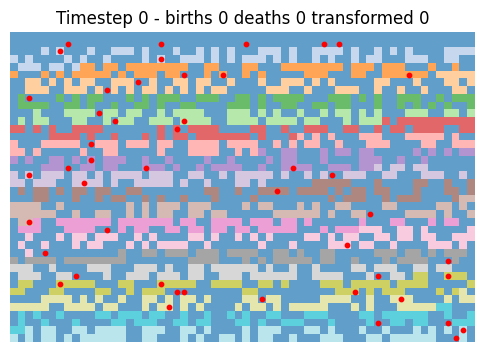

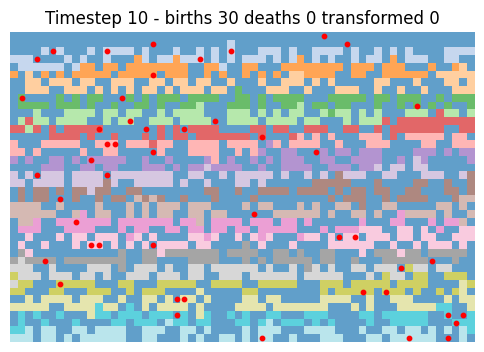

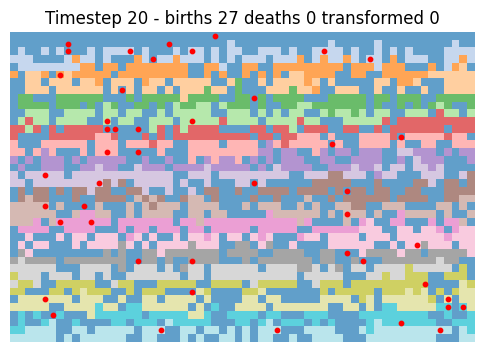

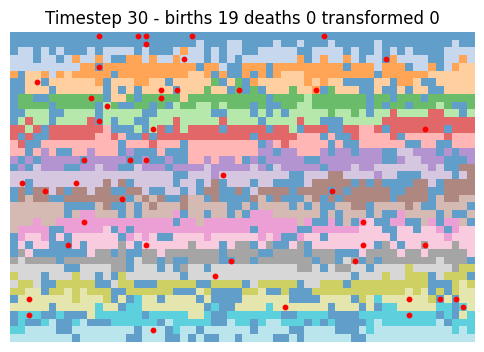

In [ ]:
# IVCSF Colab-ready simulation notebook (multi-cell agent-based extension)
# Purpose: Runnable simulation environment for a virtual cell system with
# mechanistic telomere dynamics AND an agent-based multi-cell layer (competing
# clones, immune-like phagocytes, spatial interactions). Ready for Colab.

# %% [markdown]
# # Immortal Virtual Cell Simulation Framework — Multi-cell Agent-Based Extension
#
# This file builds on the mechanistic single-cell environment and adds:
# - A 2D grid-based agent simulation where each grid cell may contain one biological cell
# - Cell behaviors: division, death (apoptosis), senescence, mutation accumulation
# - Clone labeling so you can observe clonal expansion and competition
# - Mobile phagocytes (immune-like agents) that clear debris and target apoptotic or transformed cells
# - Visualization utilities for per-step snapshots
#
# Notes:
# - Models are intentionally simplified and modular so you can replace components
#   (e.g., telomerase kinetics, repair) with higher-fidelity implementations.
# - This notebook is for computational exploration only.

# %%
!pip install --quiet stable-baselines3[extra] gym numpy matplotlib tqdm

# %%
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Reuse/define mechanistic building blocks (simplified stubs for ABM speed)
class SequenceTelomere:
    def __init__(self, repeats=180, motif_strength=1.0):
        self.repeats = repeats
        self.length_bp = 6 * repeats
        self.mutation_count = 0
        self.motif_strength = motif_strength
    def tloop_stability(self):
        return max(0.1, 0.5 + 0.01 * self.motif_strength * self.repeats - 0.005 * self.mutation_count)
    def susceptible_to_breaks(self, oxidative_stress):
        base_prob = 0.01 * oxidative_stress
        return float(np.clip(base_prob / self.tloop_stability(), 0.0, 1.0))
    def accumulate_mutation(self):
        self.mutation_count += 1
    def effective_length(self):
        return max(0.0, self.length_bp - 10.0 * self.mutation_count)

class TelomeraseKinetics:
    def __init__(self, k_cat=0.5):
        self.k_cat = k_cat
    def step(self, controller_signal, energy):
        return controller_signal * self.k_cat * 50.0  # bp-equivalent

class DNARepairModule:
    def __init__(self, hr_capacity=0.6):
        self.hr_capacity = hr_capacity
    def repair_dsb(self, dsb_count, energy):
        muts = 0
        for _ in range(int(dsb_count)):
            if random.random() > self.hr_capacity * energy:
                muts += 1
        return int(dsb_count), muts

class CellStateMinimal:
    def __init__(self, clone_id, motif_strength=1.0):
        self.tel = SequenceTelomere(repeats=180, motif_strength=motif_strength)
        self.telo_kin = TelomeraseKinetics(k_cat=0.5)
        self.repair = DNARepairModule(hr_capacity=0.6)
        self.dsb_load = 0
        self.point_mutations = 0
        self.oncogenic_mutations = 0
        self.p53_active = False
        self.senescent = False
        self.apoptotic = False
        self.clone_id = clone_id
        self.age = 0
        # simple metabolic energy
        self.energy = 1.0
    def step_damage(self, oxidative_stress):
        # small stochastic damage
        dsb = np.random.poisson(0.005 * oxidative_stress)
        ssn = np.random.poisson(0.02 * oxidative_stress)
        for _ in range(ssn):
            if random.random() < self.tel.susceptible_to_breaks(oxidative_stress):
                self.tel.accumulate_mutation(); self.point_mutations += 1
        self.dsb_load += dsb
        return ssn, dsb
    def repair_step(self):
        repaired, muts = self.repair.repair_dsb(self.dsb_load, self.energy)
        self.point_mutations += muts
        onc_hits = sum(1 for _ in range(muts) if random.random() < 0.01)
        self.oncogenic_mutations += onc_hits
        self.dsb_load = max(0, self.dsb_load - repaired)
        return repaired, muts, onc_hits
    def telomerase_action(self, controller_signal):
        bp = self.telo_kin.step(controller_signal, self.energy)
        if bp > 0 and self.tel.mutation_count>0 and random.random() < min(0.9, bp/1000.0):
            self.tel.mutation_count = max(0, self.tel.mutation_count - 1)
        return bp
    def evaluate(self):
        # determine fates
        if self.point_mutations > 200 or self.tel.effective_length() < 100:
            self.senescent = True
        if self.oncogenic_mutations >= 5 and random.random()<0.3:
            # transformed
            return 'transformed'
        if self.p53_active and random.random() < 0.5:
            self.apoptotic = True
        return 'normal'

# Agent-based grid
class ABMSpace:
    def __init__(self, width=40, height=40, initial_density=0.6):
        self.width = width; self.height = height
        self.grid = [[None for _ in range(width)] for _ in range(height)]
        self.debris = [[0.0 for _ in range(width)] for _ in range(height)]
        self.phagocytes = []  # list of (y,x) positions
        self.next_clone_id = 1
        # populate
        for y in range(height):
            for x in range(width):
                if random.random() < initial_density:
                    self.grid[y][x] = CellStateMinimal(clone_id=self._new_clone_id(), motif_strength=random.choice([0.8,1.0,1.2]))
        # add phagocytes
        for _ in range(int(0.02*width*height)):
            self.phagocytes.append((random.randrange(height), random.randrange(width)))
    def _new_clone_id(self):
        cid = self.next_clone_id; self.next_clone_id += 1; return cid
    def step(self, controller_policy=None):
        # controller_policy: function(cell, y,x)->signal
        # 1) cell actions: damage, repair, telomerase
        positions = [(y,x) for y in range(self.height) for x in range(self.width) if self.grid[y][x] is not None]
        random.shuffle(positions)
        births = []
        deaths = []
        transformed_positions = []
        for y,x in positions:
            cell = self.grid[y][x]
            # microenvironment oxidative stress depends on debris density
            oxidative = 1.0 + 0.1*self.debris[y][x]
            cell.age += 1
            ssn, dsb = cell.step_damage(oxidative)
            repaired, muts, onc = cell.repair_step()
            # compute controller signal
            if controller_policy is None:
                signal = 1.0  # baseline
            else:
                signal = controller_policy(cell,y,x)
            bp = cell.telomerase_action(signal)
            fate = cell.evaluate()
            # debris accumulation from apoptosis
            if cell.apoptotic:
                deaths.append((y,x)); self.debris[y][x] += 5.0
            elif fate == 'transformed':
                transformed_positions.append((y,x))
            else:
                # potential division if space nearby
                if cell.age>5 and random.random()<0.02:
                    ny,nx = self._find_empty_neighbor(y,x)
                    if ny is not None:
                        births.append((ny,nx,cell.clone_id))
                        cell.age = 0
        # apply births
        for ny,nx,clone in births:
            self.grid[ny][nx] = CellStateMinimal(clone_id=clone)
        # apply deaths
        for y,x in deaths:
            self.grid[y][x] = None
        # move phagocytes and clear debris/target transformed
        self._phagocyte_actions()
        return {'births':len(births),'deaths':len(deaths),'transformed':len(transformed_positions)}
    def _find_empty_neighbor(self,y,x):
        coords=[(y+dy,x+dx) for dy in (-1,0,1) for dx in (-1,0,1) if not (dx==0 and dy==0)]
        random.shuffle(coords)
        for ny,nx in coords:
            if 0<=ny<self.height and 0<=nx<self.width and self.grid[ny][nx] is None:
                return ny,nx
        return None,None
    def _phagocyte_actions(self):
        new_phagos=[]
        for (y,x) in self.phagocytes:
            # move randomly
            dy,dx = random.choice([-1,0,1]), random.choice([-1,0,1])
            ny, nx = max(0,min(self.height-1,y+dy)), max(0,min(self.width-1,x+dx))
            # clear some debris
            self.debris[ny][nx] = max(0.0, self.debris[ny][nx] - 0.5)
            # if apoptotic/transformed cell present, clear and consume
            cell = self.grid[ny][nx]
            if cell is not None and (cell.apoptotic or cell.oncogenic_mutations>3):
                self.grid[ny][nx] = None
                self.debris[ny][nx] += 1.0
            new_phagos.append((ny,nx))
        self.phagocytes = new_phagos
    def snapshot(self):
        # return arrays for visualization: clone map, debris map, phagocyte map
        clone_map = np.zeros((self.height,self.width),dtype=int)
        debris_map = np.array(self.debris)
        phago_map = np.zeros((self.height,self.width),dtype=int)
        for y in range(self.height):
            for x in range(self.width):
                c = self.grid[y][x]
                if c is not None:
                    clone_map[y,x] = c.clone_id
        for (y,x) in self.phagocytes:
            phago_map[y,x] = 1
        return clone_map, debris_map, phago_map

# Visualization utilities
def plot_snapshot(clone_map, debris_map, phago_map, title=''):
    plt.figure(figsize=(6,6))
    cmap = plt.cm.get_cmap('tab20')
    # display clones as colored points
    h,w = clone_map.shape
    plt.imshow(clone_map, cmap='tab20')
    # overlay debris as alpha
    plt.imshow(debris_map, cmap='Greys', alpha=0.3)
    # overlay phagocytes with red dots
    ys, xs = np.where(phago_map==1)
    plt.scatter(xs, ys, c='red', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Demo run
space = ABMSpace(width=60, height=40, initial_density=0.5)
for t in range(40):
    stats = space.step()
    if t%10==0:
        clone_map,debris_map,phago_map = space.snapshot()
        plot_snapshot(clone_map,debris_map,phago_map, title=f'Timestep {t} - births {stats["births"]} deaths {stats["deaths"]} transformed {stats["transformed"]}')

# End of multi-cell ABM extension

/tmp/ipython-input-2930930433.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


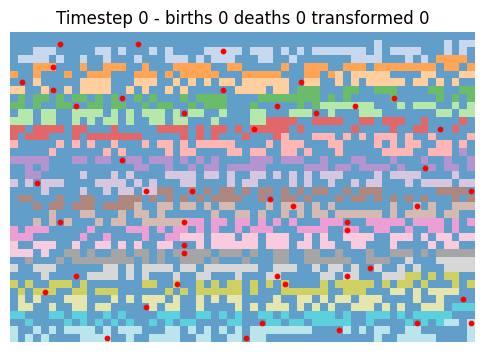

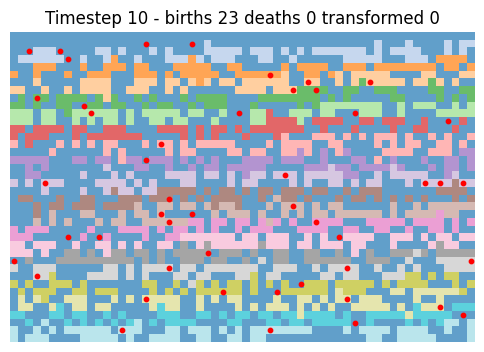

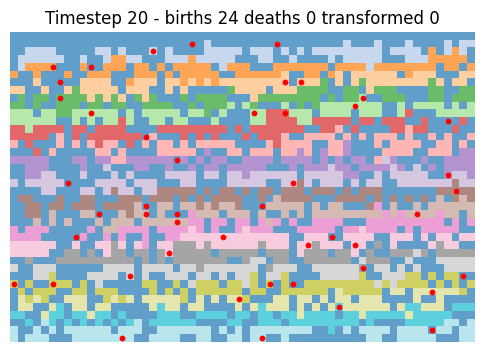

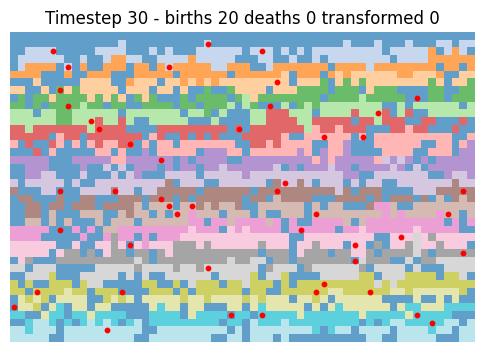

Running 27 parameter combos x 4 replicates = 108 simulations
Combo 1/27: density=0.2, phago_frac=0.01, motifs=[0.8]
Combo 2/27: density=0.2, phago_frac=0.01, motifs=[1.0]
Combo 3/27: density=0.2, phago_frac=0.01, motifs=[1.2]
Combo 4/27: density=0.2, phago_frac=0.03, motifs=[0.8]
Combo 5/27: density=0.2, phago_frac=0.03, motifs=[1.0]
Combo 6/27: density=0.2, phago_frac=0.03, motifs=[1.2]
Combo 7/27: density=0.2, phago_frac=0.06, motifs=[0.8]
Combo 8/27: density=0.2, phago_frac=0.06, motifs=[1.0]
Combo 9/27: density=0.2, phago_frac=0.06, motifs=[1.2]
Combo 10/27: density=0.5, phago_frac=0.01, motifs=[0.8]
Combo 11/27: density=0.5, phago_frac=0.01, motifs=[1.0]
Combo 12/27: density=0.5, phago_frac=0.01, motifs=[1.2]
Combo 13/27: density=0.5, phago_frac=0.03, motifs=[0.8]
Combo 14/27: density=0.5, phago_frac=0.03, motifs=[1.0]
Combo 15/27: density=0.5, phago_frac=0.03, motifs=[1.2]
Combo 16/27: density=0.5, phago_frac=0.06, motifs=[0.8]
Combo 17/27: density=0.5, phago_frac=0.06, motifs=[1

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


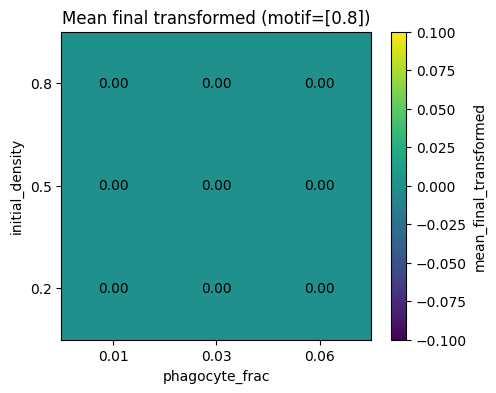

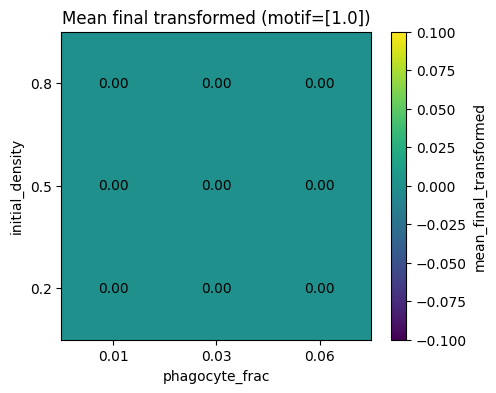

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


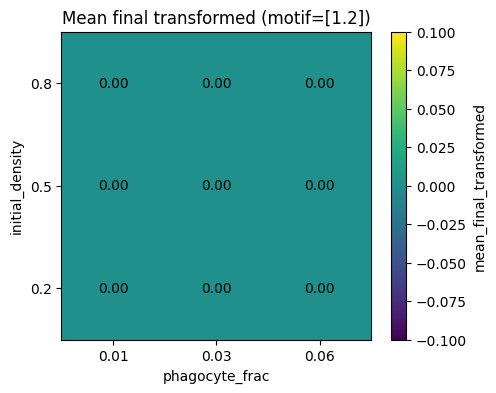

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


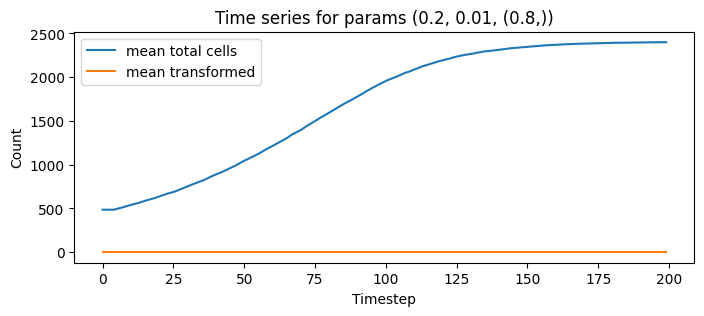

In [ ]:
# IVCSF Colab-ready simulation notebook (multi-cell agent-based extension)
# Purpose: Runnable simulation environment for a virtual cell system with
# mechanistic telomere dynamics AND an agent-based multi-cell layer (competing
# clones, immune-like phagocytes, spatial interactions). Ready for Colab.

# %% [markdown]
# # Immortal Virtual Cell Simulation Framework — Multi-cell Agent-Based Extension
#
# This file builds on the mechanistic single-cell environment and adds:
# - A 2D grid-based agent simulation where each grid cell may contain one biological cell
# - Cell behaviors: division, death (apoptosis), senescence, mutation accumulation
# - Clone labeling so you can observe clonal expansion and competition
# - Mobile phagocytes (immune-like agents) that clear debris and target apoptotic or transformed cells
# - Visualization utilities for per-step snapshots
#
# Notes:
# - Models are intentionally simplified and modular so you can replace components
#   (e.g., telomerase kinetics, repair) with higher-fidelity implementations.
# - This notebook is for computational exploration only.

# %%
!pip install --quiet stable-baselines3[extra] gym numpy matplotlib tqdm

# %%
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Reuse/define mechanistic building blocks (simplified stubs for ABM speed)
class SequenceTelomere:
    def __init__(self, repeats=180, motif_strength=1.0):
        self.repeats = repeats
        self.length_bp = 6 * repeats
        self.mutation_count = 0
        self.motif_strength = motif_strength
    def tloop_stability(self):
        return max(0.1, 0.5 + 0.01 * self.motif_strength * self.repeats - 0.005 * self.mutation_count)
    def susceptible_to_breaks(self, oxidative_stress):
        base_prob = 0.01 * oxidative_stress
        return float(np.clip(base_prob / self.tloop_stability(), 0.0, 1.0))
    def accumulate_mutation(self):
        self.mutation_count += 1
    def effective_length(self):
        return max(0.0, self.length_bp - 10.0 * self.mutation_count)

class TelomeraseKinetics:
    def __init__(self, k_cat=0.5):
        self.k_cat = k_cat
    def step(self, controller_signal, energy):
        return controller_signal * self.k_cat * 50.0  # bp-equivalent

class DNARepairModule:
    def __init__(self, hr_capacity=0.6):
        self.hr_capacity = hr_capacity
    def repair_dsb(self, dsb_count, energy):
        muts = 0
        for _ in range(int(dsb_count)):
            if random.random() > self.hr_capacity * energy:
                muts += 1
        return int(dsb_count), muts

class CellStateMinimal:
    def __init__(self, clone_id, motif_strength=1.0):
        self.tel = SequenceTelomere(repeats=180, motif_strength=motif_strength)
        self.telo_kin = TelomeraseKinetics(k_cat=0.5)
        self.repair = DNARepairModule(hr_capacity=0.6)
        self.dsb_load = 0
        self.point_mutations = 0
        self.oncogenic_mutations = 0
        self.p53_active = False
        self.senescent = False
        self.apoptotic = False
        self.clone_id = clone_id
        self.age = 0
        # simple metabolic energy
        self.energy = 1.0
    def step_damage(self, oxidative_stress):
        # small stochastic damage
        dsb = np.random.poisson(0.005 * oxidative_stress)
        ssn = np.random.poisson(0.02 * oxidative_stress)
        for _ in range(ssn):
            if random.random() < self.tel.susceptible_to_breaks(oxidative_stress):
                self.tel.accumulate_mutation(); self.point_mutations += 1
        self.dsb_load += dsb
        return ssn, dsb
    def repair_step(self):
        repaired, muts = self.repair.repair_dsb(self.dsb_load, self.energy)
        self.point_mutations += muts
        onc_hits = sum(1 for _ in range(muts) if random.random() < 0.01)
        self.oncogenic_mutations += onc_hits
        self.dsb_load = max(0, self.dsb_load - repaired)
        return repaired, muts, onc_hits
    def telomerase_action(self, controller_signal):
        bp = self.telo_kin.step(controller_signal, self.energy)
        if bp > 0 and self.tel.mutation_count>0 and random.random() < min(0.9, bp/1000.0):
            self.tel.mutation_count = max(0, self.tel.mutation_count - 1)
        return bp
    def evaluate(self):
        # determine fates
        if self.point_mutations > 200 or self.tel.effective_length() < 100:
            self.senescent = True
        if self.oncogenic_mutations >= 5 and random.random()<0.3:
            # transformed
            return 'transformed'
        if self.p53_active and random.random() < 0.5:
            self.apoptotic = True
        return 'normal'

# Agent-based grid
class ABMSpace:
    def __init__(self, width=40, height=40, initial_density=0.6):
        self.width = width; self.height = height
        self.grid = [[None for _ in range(width)] for _ in range(height)]
        self.debris = [[0.0 for _ in range(width)] for _ in range(height)]
        self.phagocytes = []  # list of (y,x) positions
        self.next_clone_id = 1
        # populate
        for y in range(height):
            for x in range(width):
                if random.random() < initial_density:
                    self.grid[y][x] = CellStateMinimal(clone_id=self._new_clone_id(), motif_strength=random.choice([0.8,1.0,1.2]))
        # add phagocytes
        for _ in range(int(0.02*width*height)):
            self.phagocytes.append((random.randrange(height), random.randrange(width)))
    def _new_clone_id(self):
        cid = self.next_clone_id; self.next_clone_id += 1; return cid
    def step(self, controller_policy=None):
        # controller_policy: function(cell, y,x)->signal
        # 1) cell actions: damage, repair, telomerase
        positions = [(y,x) for y in range(self.height) for x in range(self.width) if self.grid[y][x] is not None]
        random.shuffle(positions)
        births = []
        deaths = []
        transformed_positions = []
        for y,x in positions:
            cell = self.grid[y][x]
            # microenvironment oxidative stress depends on debris density
            oxidative = 1.0 + 0.1*self.debris[y][x]
            cell.age += 1
            ssn, dsb = cell.step_damage(oxidative)
            repaired, muts, onc = cell.repair_step()
            # compute controller signal
            if controller_policy is None:
                signal = 1.0  # baseline
            else:
                signal = controller_policy(cell,y,x)
            bp = cell.telomerase_action(signal)
            fate = cell.evaluate()
            # debris accumulation from apoptosis
            if cell.apoptotic:
                deaths.append((y,x)); self.debris[y][x] += 5.0
            elif fate == 'transformed':
                transformed_positions.append((y,x))
            else:
                # potential division if space nearby
                if cell.age>5 and random.random()<0.02:
                    ny,nx = self._find_empty_neighbor(y,x)
                    if ny is not None:
                        births.append((ny,nx,cell.clone_id))
                        cell.age = 0
        # apply births
        for ny,nx,clone in births:
            self.grid[ny][nx] = CellStateMinimal(clone_id=clone)
        # apply deaths
        for y,x in deaths:
            self.grid[y][x] = None
        # move phagocytes and clear debris/target transformed
        self._phagocyte_actions()
        return {'births':len(births),'deaths':len(deaths),'transformed':len(transformed_positions)}
    def _find_empty_neighbor(self,y,x):
        coords=[(y+dy,x+dx) for dy in (-1,0,1) for dx in (-1,0,1) if not (dx==0 and dy==0)]
        random.shuffle(coords)
        for ny,nx in coords:
            if 0<=ny<self.height and 0<=nx<self.width and self.grid[ny][nx] is None:
                return ny,nx
        return None,None
    def _phagocyte_actions(self):
        new_phagos=[]
        for (y,x) in self.phagocytes:
            # move randomly
            dy,dx = random.choice([-1,0,1]), random.choice([-1,0,1])
            ny, nx = max(0,min(self.height-1,y+dy)), max(0,min(self.width-1,x+dx))
            # clear some debris
            self.debris[ny][nx] = max(0.0, self.debris[ny][nx] - 0.5)
            # if apoptotic/transformed cell present, clear and consume
            cell = self.grid[ny][nx]
            if cell is not None and (cell.apoptotic or cell.oncogenic_mutations>3):
                self.grid[ny][nx] = None
                self.debris[ny][nx] += 1.0
            new_phagos.append((ny,nx))
        self.phagocytes = new_phagos
    def snapshot(self):
        # return arrays for visualization: clone map, debris map, phagocyte map
        clone_map = np.zeros((self.height,self.width),dtype=int)
        debris_map = np.array(self.debris)
        phago_map = np.zeros((self.height,self.width),dtype=int)
        for y in range(self.height):
            for x in range(self.width):
                c = self.grid[y][x]
                if c is not None:
                    clone_map[y,x] = c.clone_id
        for (y,x) in self.phagocytes:
            phago_map[y,x] = 1
        return clone_map, debris_map, phago_map

# Visualization utilities
def plot_snapshot(clone_map, debris_map, phago_map, title=''):
    plt.figure(figsize=(6,6))
    cmap = plt.cm.get_cmap('tab20')
    # display clones as colored points
    h,w = clone_map.shape
    plt.imshow(clone_map, cmap='tab20')
    # overlay debris as alpha
    plt.imshow(debris_map, cmap='Greys', alpha=0.3)
    # overlay phagocytes with red dots
    ys, xs = np.where(phago_map==1)
    plt.scatter(xs, ys, c='red', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Demo run
space = ABMSpace(width=60, height=40, initial_density=0.5)
for t in range(40):
    stats = space.step()
    if t%10==0:
        clone_map,debris_map,phago_map = space.snapshot()
        plot_snapshot(clone_map,debris_map,phago_map, title=f'Timestep {t} - births {stats["births"]} deaths {stats["deaths"]} transformed {stats["transformed"]}')

# End of multi-cell ABM extension

# %% [markdown]
# ## Parameter tuning and multi-replicate experiments
# The block below runs parameter sweeps across initial cell density, phagocyte
# fraction, and motif_strength. It executes multiple replicates per parameter
# combination and summarizes outcomes: births, deaths, transformed cell counts,
# and debris dynamics. Default settings are conservative so runs complete in a
# reasonable time in Colab.

# %%
import itertools
import pickle

def run_experiment(width=60, height=40, initial_density=0.5, phagocyte_frac=0.02, motif_strengths=[1.0], timesteps=200, replicates=3, seed_base=0):
    results = []
    for rep in range(replicates):
        rng_seed = seed_base + rep
        space = ABMSpace(width=width, height=height, initial_density=initial_density)
        # adjust phagocyte count
        desired_phagos = int(phagocyte_frac * width * height)
        # randomly reassign phagocytes to match desired count
        space.phagocytes = [(random.randrange(space.height), random.randrange(space.width)) for _ in range(desired_phagos)]
        # set motif strengths for all existing cells
        for y in range(space.height):
            for x in range(space.width):
                c = space.grid[y][x]
                if c is not None:
                    c.tel.motif_strength = random.choice(motif_strengths)
        stats_time = {'births':[], 'deaths':[], 'transformed':[], 'total_cells':[], 'total_debris':[]}
        for t in range(timesteps):
            s = space.step()
            # compute aggregates
            total_cells = sum(1 for y in range(space.height) for x in range(space.width) if space.grid[y][x] is not None)
            total_debris = sum(space.debris[y][x] for y in range(space.height) for x in range(space.width))
            stats_time['births'].append(s['births']); stats_time['deaths'].append(s['deaths']); stats_time['transformed'].append(s['transformed']); stats_time['total_cells'].append(total_cells); stats_time['total_debris'].append(total_debris)
        results.append(stats_time)
    return results

# %%
# Sweep configuration (default grid). This will run multiple replicates for each
# parameter combination. Adjust `replicates` and `timesteps` if you need faster runs.
initial_densities = [0.2, 0.5, 0.8]
phagocyte_fracs = [0.01, 0.03, 0.06]
motif_strengths_list = [[0.8], [1.0], [1.2]]
replicates = 4
timesteps = 200

sweep_results = {}
combos = list(itertools.product(initial_densities, phagocyte_fracs, range(len(motif_strengths_list))))
print(f"Running {len(combos)} parameter combos x {replicates} replicates = {len(combos)*replicates} simulations")

for i, (dens, phago_frac, motif_idx) in enumerate(combos):
    motifs = motif_strengths_list[motif_idx]
    print(f"Combo {i+1}/{len(combos)}: density={dens}, phago_frac={phago_frac}, motifs={motifs}")
    res = run_experiment(width=60, height=40, initial_density=dens, phagocyte_frac=phago_frac, motif_strengths=motifs, timesteps=timesteps, replicates=replicates, seed_base=1000*i)
    sweep_results[(dens, phago_frac, tuple(motifs))] = res

# Save results to file for later analysis
with open('abm_sweep_results.pkl', 'wb') as f:
    pickle.dump(sweep_results, f)
print('Saved sweep results to abm_sweep_results.pkl')

# %%
# Analysis and summary plotting
import pandas as pd

# Aggregate metrics: average transformed fraction at final timestep and mean total_cells
summary_rows = []
for params, runs in sweep_results.items():
    dens, phago_frac, motifs = params
    final_transformed = []
    final_cells = []
    for r in runs:
        final_transformed.append(r['transformed'][-1])
        final_cells.append(r['total_cells'][-1])
    row = {
        'initial_density': dens,
        'phagocyte_frac': phago_frac,
        'motifs': motifs,
        'mean_final_transformed': float(np.mean(final_transformed)),
        'std_final_transformed': float(np.std(final_transformed)),
        'mean_final_cells': float(np.mean(final_cells)),
        'std_final_cells': float(np.std(final_cells))
    }
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print(summary_df)

# %%
# Heatmap: mean_final_transformed across density x phagocyte fraction for each motif setting
for motif in motif_strengths_list:
    pivot = summary_df[summary_df['motifs'].apply(lambda x: tuple(x)==tuple(motif))].pivot(index='initial_density', columns='phagocyte_frac', values='mean_final_transformed')
    plt.figure(figsize=(5,4))
    plt.title(f"Mean final transformed (motif={motif})")
    plt.imshow(pivot.values, origin='lower', aspect='auto')
    plt.xticks(ticks=range(len(pivot.columns)), labels=[str(c) for c in pivot.columns])
    plt.yticks(ticks=range(len(pivot.index)), labels=[str(i) for i in pivot.index])
    plt.xlabel('phagocyte_frac'); plt.ylabel('initial_density')
    for (j,i),val in np.ndenumerate(pivot.values):
        plt.text(i,j,f"{val:.2f}",ha='center',va='center',color='white' if val>np.nanmax(pivot.values)/2 else 'black')
    plt.colorbar(label='mean_final_transformed')
    plt.show()

# %%
# Time-series plots: mean total cells and mean transformed across timesteps for selected combo
# pick first combo as example
example_params = list(sweep_results.keys())[0]
runs = sweep_results[example_params]
mean_cells = np.mean([r['total_cells'] for r in runs], axis=0)
mean_trans = np.mean([r['transformed'] for r in runs], axis=0)
plt.figure(figsize=(8,3))
plt.plot(mean_cells, label='mean total cells')
plt.plot(mean_trans, label='mean transformed')
plt.xlabel('Timestep'); plt.ylabel('Count'); plt.legend(); plt.title(f'Time series for params {example_params}')
plt.show()

# %% [markdown]
# ## Notes & next steps
# * You can reduce `replicates` or `timesteps` for faster exploratory runs. For publication-quality parameter sweeps, increase replicates and consider using multiprocessing to parallelize runs.
# * If you'd like, I can convert the notebook into a downloadable `.ipynb` with these experiments pre-run and plots embedded, or add a Colab-friendly UI (sliders) to run selected parameter sets interactively.

/tmp/ipython-input-2748644296.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


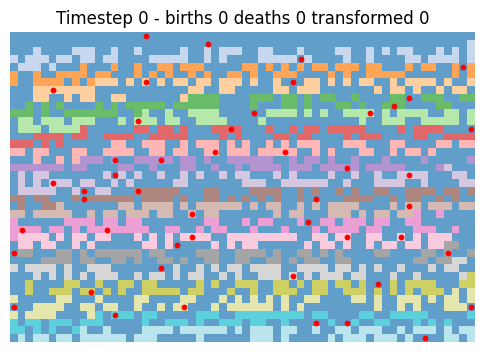

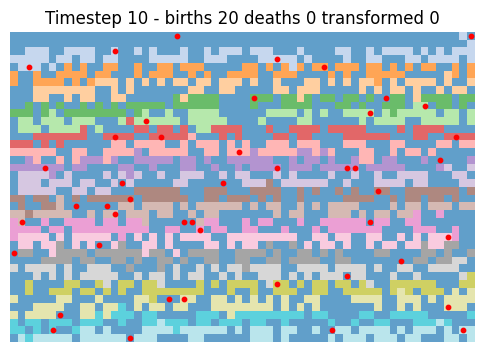

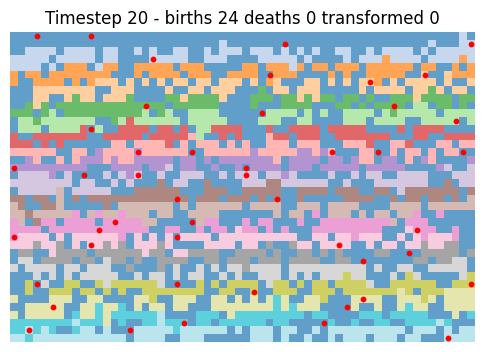

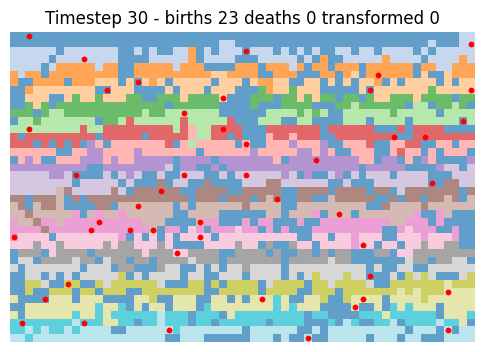

Total tasks: 108  Pending: 108  Completed: 0
Using 1 workers for multiprocessing


/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=159) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Checkpoint saved: 6 tasks completed.
Checkpoint saved: 12 tasks completed.
Checkpoint saved: 18 tasks completed.
Checkpoint saved: 24 tasks completed.
Checkpoint saved: 30 tasks completed.
Checkpoint saved: 36 tasks completed.
Checkpoint saved: 42 tasks completed.
Checkpoint saved: 48 tasks completed.
Checkpoint saved: 54 tasks completed.
Checkpoint saved: 60 tasks completed.
Checkpoint saved: 66 tasks completed.
Checkpoint saved: 72 tasks completed.
Checkpoint saved: 78 tasks completed.
Checkpoint saved: 84 tasks completed.
Checkpoint saved: 90 tasks completed.
Checkpoint saved: 96 tasks completed.
Checkpoint saved: 102 tasks completed.
Checkpoint saved: 108 tasks completed.
Saved aggregated results to abm_sweep_results.pkl
    initial_density  phagocyte_frac  motifs  mean_final_transformed  \
0               0.2            0.01  (0.8,)                     0.0   
1               0.2            0.01  (1.0,)                     0.0   
2               0.2            0.01  (1.2,)         

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


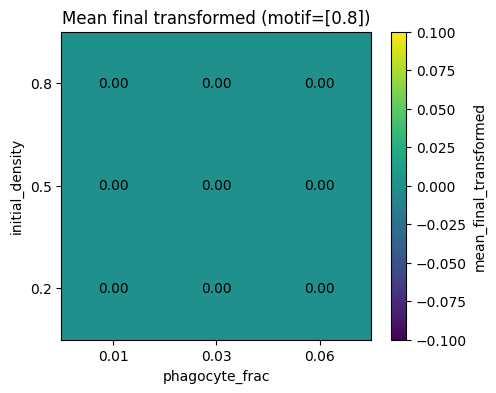

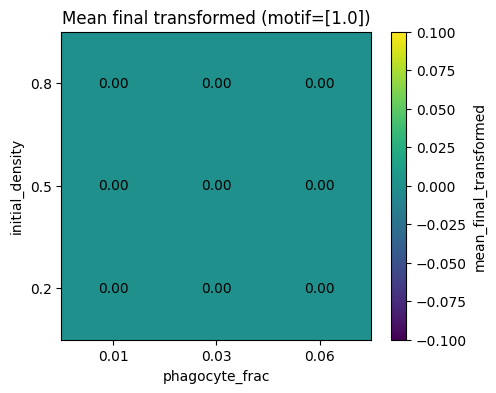

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


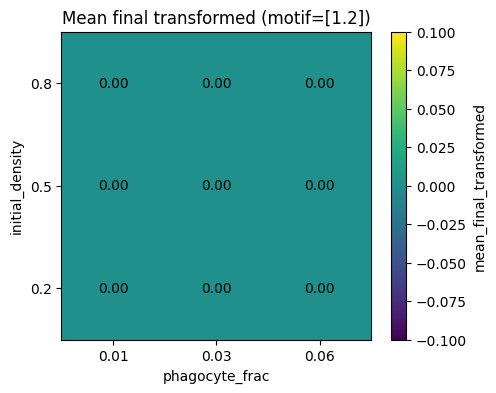

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


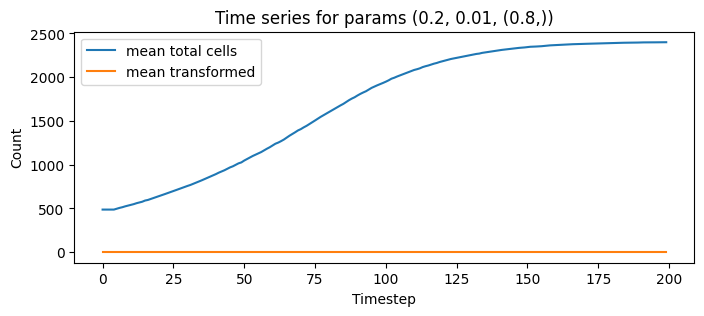

In [ ]:
# IVCSF Colab-ready simulation notebook (multi-cell agent-based extension)
# Purpose: Runnable simulation environment for a virtual cell system with
# mechanistic telomere dynamics AND an agent-based multi-cell layer (competing
# clones, immune-like phagocytes, spatial interactions). Ready for Colab.

# %% [markdown]
# # Immortal Virtual Cell Simulation Framework — Multi-cell Agent-Based Extension
#
# This file builds on the mechanistic single-cell environment and adds:
# - A 2D grid-based agent simulation where each grid cell may contain one biological cell
# - Cell behaviors: division, death (apoptosis), senescence, mutation accumulation
# - Clone labeling so you can observe clonal expansion and competition
# - Mobile phagocytes (immune-like agents) that clear debris and target apoptotic or transformed cells
# - Visualization utilities for per-step snapshots
#
# Notes:
# - Models are intentionally simplified and modular so you can replace components
#   (e.g., telomerase kinetics, repair) with higher-fidelity implementations.
# - This notebook is for computational exploration only.

# %%
!pip install --quiet stable-baselines3[extra] gym numpy matplotlib tqdm

# %%
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Reuse/define mechanistic building blocks (simplified stubs for ABM speed)
class SequenceTelomere:
    def __init__(self, repeats=180, motif_strength=1.0):
        self.repeats = repeats
        self.length_bp = 6 * repeats
        self.mutation_count = 0
        self.motif_strength = motif_strength
    def tloop_stability(self):
        return max(0.1, 0.5 + 0.01 * self.motif_strength * self.repeats - 0.005 * self.mutation_count)
    def susceptible_to_breaks(self, oxidative_stress):
        base_prob = 0.01 * oxidative_stress
        return float(np.clip(base_prob / self.tloop_stability(), 0.0, 1.0))
    def accumulate_mutation(self):
        self.mutation_count += 1
    def effective_length(self):
        return max(0.0, self.length_bp - 10.0 * self.mutation_count)

class TelomeraseKinetics:
    def __init__(self, k_cat=0.5):
        self.k_cat = k_cat
    def step(self, controller_signal, energy):
        return controller_signal * self.k_cat * 50.0  # bp-equivalent

class DNARepairModule:
    def __init__(self, hr_capacity=0.6):
        self.hr_capacity = hr_capacity
    def repair_dsb(self, dsb_count, energy):
        muts = 0
        for _ in range(int(dsb_count)):
            if random.random() > self.hr_capacity * energy:
                muts += 1
        return int(dsb_count), muts

class CellStateMinimal:
    def __init__(self, clone_id, motif_strength=1.0):
        self.tel = SequenceTelomere(repeats=180, motif_strength=motif_strength)
        self.telo_kin = TelomeraseKinetics(k_cat=0.5)
        self.repair = DNARepairModule(hr_capacity=0.6)
        self.dsb_load = 0
        self.point_mutations = 0
        self.oncogenic_mutations = 0
        self.p53_active = False
        self.senescent = False
        self.apoptotic = False
        self.clone_id = clone_id
        self.age = 0
        # simple metabolic energy
        self.energy = 1.0
    def step_damage(self, oxidative_stress):
        # small stochastic damage
        dsb = np.random.poisson(0.005 * oxidative_stress)
        ssn = np.random.poisson(0.02 * oxidative_stress)
        for _ in range(ssn):
            if random.random() < self.tel.susceptible_to_breaks(oxidative_stress):
                self.tel.accumulate_mutation(); self.point_mutations += 1
        self.dsb_load += dsb
        return ssn, dsb
    def repair_step(self):
        repaired, muts = self.repair.repair_dsb(self.dsb_load, self.energy)
        self.point_mutations += muts
        onc_hits = sum(1 for _ in range(muts) if random.random() < 0.01)
        self.oncogenic_mutations += onc_hits
        self.dsb_load = max(0, self.dsb_load - repaired)
        return repaired, muts, onc_hits
    def telomerase_action(self, controller_signal):
        bp = self.telo_kin.step(controller_signal, self.energy)
        if bp > 0 and self.tel.mutation_count>0 and random.random() < min(0.9, bp/1000.0):
            self.tel.mutation_count = max(0, self.tel.mutation_count - 1)
        return bp
    def evaluate(self):
        # determine fates
        if self.point_mutations > 200 or self.tel.effective_length() < 100:
            self.senescent = True
        if self.oncogenic_mutations >= 5 and random.random()<0.3:
            # transformed
            return 'transformed'
        if self.p53_active and random.random() < 0.5:
            self.apoptotic = True
        return 'normal'

# Agent-based grid
class ABMSpace:
    def __init__(self, width=40, height=40, initial_density=0.6):
        self.width = width; self.height = height
        self.grid = [[None for _ in range(width)] for _ in range(height)]
        self.debris = [[0.0 for _ in range(width)] for _ in range(height)]
        self.phagocytes = []  # list of (y,x) positions
        self.next_clone_id = 1
        # populate
        for y in range(height):
            for x in range(width):
                if random.random() < initial_density:
                    self.grid[y][x] = CellStateMinimal(clone_id=self._new_clone_id(), motif_strength=random.choice([0.8,1.0,1.2]))
        # add phagocytes
        for _ in range(int(0.02*width*height)):
            self.phagocytes.append((random.randrange(height), random.randrange(width)))
    def _new_clone_id(self):
        cid = self.next_clone_id; self.next_clone_id += 1; return cid
    def step(self, controller_policy=None):
        # controller_policy: function(cell, y,x)->signal
        # 1) cell actions: damage, repair, telomerase
        positions = [(y,x) for y in range(self.height) for x in range(self.width) if self.grid[y][x] is not None]
        random.shuffle(positions)
        births = []
        deaths = []
        transformed_positions = []
        for y,x in positions:
            cell = self.grid[y][x]
            # microenvironment oxidative stress depends on debris density
            oxidative = 1.0 + 0.1*self.debris[y][x]
            cell.age += 1
            ssn, dsb = cell.step_damage(oxidative)
            repaired, muts, onc = cell.repair_step()
            # compute controller signal
            if controller_policy is None:
                signal = 1.0  # baseline
            else:
                signal = controller_policy(cell,y,x)
            bp = cell.telomerase_action(signal)
            fate = cell.evaluate()
            # debris accumulation from apoptosis
            if cell.apoptotic:
                deaths.append((y,x)); self.debris[y][x] += 5.0
            elif fate == 'transformed':
                transformed_positions.append((y,x))
            else:
                # potential division if space nearby
                if cell.age>5 and random.random()<0.02:
                    ny,nx = self._find_empty_neighbor(y,x)
                    if ny is not None:
                        births.append((ny,nx,cell.clone_id))
                        cell.age = 0
        # apply births
        for ny,nx,clone in births:
            self.grid[ny][nx] = CellStateMinimal(clone_id=clone)
        # apply deaths
        for y,x in deaths:
            self.grid[y][x] = None
        # move phagocytes and clear debris/target transformed
        self._phagocyte_actions()
        return {'births':len(births),'deaths':len(deaths),'transformed':len(transformed_positions)}
    def _find_empty_neighbor(self,y,x):
        coords=[(y+dy,x+dx) for dy in (-1,0,1) for dx in (-1,0,1) if not (dx==0 and dy==0)]
        random.shuffle(coords)
        for ny,nx in coords:
            if 0<=ny<self.height and 0<=nx<self.width and self.grid[ny][nx] is None:
                return ny,nx
        return None,None
    def _phagocyte_actions(self):
        new_phagos=[]
        for (y,x) in self.phagocytes:
            # move randomly
            dy,dx = random.choice([-1,0,1]), random.choice([-1,0,1])
            ny, nx = max(0,min(self.height-1,y+dy)), max(0,min(self.width-1,x+dx))
            # clear some debris
            self.debris[ny][nx] = max(0.0, self.debris[ny][nx] - 0.5)
            # if apoptotic/transformed cell present, clear and consume
            cell = self.grid[ny][nx]
            if cell is not None and (cell.apoptotic or cell.oncogenic_mutations>3):
                self.grid[ny][nx] = None
                self.debris[ny][nx] += 1.0
            new_phagos.append((ny,nx))
        self.phagocytes = new_phagos
    def snapshot(self):
        # return arrays for visualization: clone map, debris map, phagocyte map
        clone_map = np.zeros((self.height,self.width),dtype=int)
        debris_map = np.array(self.debris)
        phago_map = np.zeros((self.height,self.width),dtype=int)
        for y in range(self.height):
            for x in range(self.width):
                c = self.grid[y][x]
                if c is not None:
                    clone_map[y,x] = c.clone_id
        for (y,x) in self.phagocytes:
            phago_map[y,x] = 1
        return clone_map, debris_map, phago_map

# Visualization utilities
def plot_snapshot(clone_map, debris_map, phago_map, title=''):
    plt.figure(figsize=(6,6))
    cmap = plt.cm.get_cmap('tab20')
    # display clones as colored points
    h,w = clone_map.shape
    plt.imshow(clone_map, cmap='tab20')
    # overlay debris as alpha
    plt.imshow(debris_map, cmap='Greys', alpha=0.3)
    # overlay phagocytes with red dots
    ys, xs = np.where(phago_map==1)
    plt.scatter(xs, ys, c='red', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Demo run
space = ABMSpace(width=60, height=40, initial_density=0.5)
for t in range(40):
    stats = space.step()
    if t%10==0:
        clone_map,debris_map,phago_map = space.snapshot()
        plot_snapshot(clone_map,debris_map,phago_map, title=f'Timestep {t} - births {stats["births"]} deaths {stats["deaths"]} transformed {stats["transformed"]}')

# End of multi-cell ABM extension

# %% [markdown]
# ## Parameter tuning and multi-replicate experiments
# This block runs parameter sweeps across initial cell density, phagocyte
# fraction, and motif_strength using multiprocessing for speed. It supports
# resumable checkpoints: intermediate results are saved to disk periodically
# so long runs can be resumed after interruption.

# %%
import itertools
import pickle
import os
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm

CHECKPOINT_FILE = 'abm_sweep_results_checkpoint.pkl'

def single_run_wrapper(params, seed_offset=0, timesteps=200):
    """Run a single replicate for given parameter tuple.
    params: (width, height, initial_density, phagocyte_frac, motifs, seed)
    Returns a dict of summary statistics and the time-series.
    """
    width, height, initial_density, phagocyte_frac, motifs, seed = params
    # Initialize space with deterministic-ish randomness using seed
    random.seed(seed); np.random.seed(seed)
    space = ABMSpace(width=width, height=height, initial_density=initial_density)
    desired_phagos = int(phagocyte_frac * width * height)
    space.phagocytes = [(random.randrange(space.height), random.randrange(space.width)) for _ in range(desired_phagos)]
    # set motif strengths
    for y in range(space.height):
        for x in range(space.width):
            c = space.grid[y][x]
            if c is not None:
                c.tel.motif_strength = random.choice(motifs)
    stats_time = {'births':[], 'deaths':[], 'transformed':[], 'total_cells':[], 'total_debris':[]}
    for t in range(timesteps):
        s = space.step()
        total_cells = sum(1 for y in range(space.height) for x in range(space.width) if space.grid[y][x] is not None)
        total_debris = sum(space.debris[y][x] for y in range(space.height) for x in range(space.width))
        stats_time['births'].append(s['births']); stats_time['deaths'].append(s['deaths']); stats_time['transformed'].append(s['transformed']); stats_time['total_cells'].append(total_cells); stats_time['total_debris'].append(total_debris)
    summary = {
        'params': (width, height, initial_density, phagocyte_frac, tuple(motifs), seed),
        'final_transformed': stats_time['transformed'][-1],
        'final_cells': stats_time['total_cells'][-1],
        'timeseries': stats_time
    }
    return summary


def run_sweep_multiproc(initial_densities=[0.2,0.5,0.8], phagocyte_fracs=[0.01,0.03,0.06], motif_strengths_list=[[0.8],[1.0],[1.2]], replicates=4, timesteps=200, width=60, height=40, checkpoint_every=10):
    # Build list of parameter combinations (each replicate has its own random seed)
    combos = list(itertools.product(initial_densities, phagocyte_fracs, motif_strengths_list))
    tasks = []
    seed_base = 10000
    for i, (dens, phago_frac, motifs) in enumerate(combos):
        for rep in range(replicates):
            seed = seed_base + i*replicates + rep
            tasks.append((width, height, dens, phago_frac, motifs, seed))

    # Load checkpoint if present
    completed = []
    results = []
    if os.path.exists(CHECKPOINT_FILE):
        print(f"Found checkpoint {CHECKPOINT_FILE}, loading...")
        with open(CHECKPOINT_FILE, 'rb') as f:
            data = pickle.load(f)
            completed = data.get('completed', [])
            results = data.get('results', [])
        print(f"Resuming: {len(completed)} tasks already completed.")

    # Filter tasks to run
    pending_tasks = [t for t in tasks if (t not in completed)]
    print(f"Total tasks: {len(tasks)}  Pending: {len(pending_tasks)}  Completed: {len(completed)}")

    # Multiprocessing pool
    n_workers = max(1, min(cpu_count()-1, 8))
    print(f"Using {n_workers} workers for multiprocessing")
    with Pool(processes=n_workers) as pool:
        # Use imap_unordered for progress reporting
        for i, res in enumerate(pool.imap_unordered(partial(single_run_wrapper, timesteps=timesteps), pending_tasks)):
            results.append(res)
            completed.append(pending_tasks[i])
            # checkpoint periodically
            if (len(completed) % checkpoint_every) == 0:
                with open(CHECKPOINT_FILE, 'wb') as f:
                    pickle.dump({'completed': completed, 'results': results}, f)
                print(f"Checkpoint saved: {len(completed)} tasks completed.")
    # final save
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump({'completed': completed, 'results': results}, f)
    return results

# %%
# Example invocation: run a modest sweep using multiprocessing (adjust replicates/timesteps as needed)
initial_densities = [0.2, 0.5, 0.8]
phagocyte_fracs = [0.01, 0.03, 0.06]
motif_strengths_list = [[0.8], [1.0], [1.2]]
replicates = 4
timesteps = 200

# Run the sweep (this will create or append to the checkpoint file)
sweep_results_list = run_sweep_multiproc(initial_densities=initial_densities, phagocyte_fracs=phagocyte_fracs, motif_strengths_list=motif_strengths_list, replicates=replicates, timesteps=timesteps, width=60, height=40, checkpoint_every=6)

# Convert results list into structured dict keyed by params for compatibility with previous analysis code
sweep_results = {}
for r in sweep_results_list:
    params = r['params'][2], r['params'][3], r['params'][4]  # (density, phago_frac, motifs)
    key = (params[0], params[1], tuple(params[2]))
    sweep_results.setdefault(key, []).append(r)

# Save a human-readable aggregated pickle
with open('abm_sweep_results.pkl', 'wb') as f:
    pickle.dump(sweep_results, f)
print('Saved aggregated results to abm_sweep_results.pkl')

# %%
# Analysis & plotting (same as before) — build a DataFrame summary
import pandas as pd
summary_rows = []
for params, runs in sweep_results.items():
    dens, phago_frac, motifs = params
    final_transformed = [run['final_transformed'] for run in runs]
    final_cells = [run['final_cells'] for run in runs]
    row = {
        'initial_density': dens,
        'phagocyte_frac': phago_frac,
        'motifs': motifs,
        'mean_final_transformed': float(np.mean(final_transformed)),
        'std_final_transformed': float(np.std(final_transformed)),
        'mean_final_cells': float(np.mean(final_cells)),
        'std_final_cells': float(np.std(final_cells))
    }
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
print(summary_df)

# Heatmaps and time-series plotting (re-used from previous section)
for motif in motif_strengths_list:
    pivot = summary_df[summary_df['motifs'].apply(lambda x: tuple(x)==tuple(motif))].pivot(index='initial_density', columns='phagocyte_frac', values='mean_final_transformed')
    plt.figure(figsize=(5,4))
    plt.title(f"Mean final transformed (motif={motif})")
    plt.imshow(pivot.values, origin='lower', aspect='auto')
    plt.xticks(ticks=range(len(pivot.columns)), labels=[str(c) for c in pivot.columns])
    plt.yticks(ticks=range(len(pivot.index)), labels=[str(i) for i in pivot.index])
    plt.xlabel('phagocyte_frac'); plt.ylabel('initial_density')
    for (j,i),val in np.ndenumerate(pivot.values):
        plt.text(i,j,f"{val:.2f}",ha='center',va='center',color='white' if val>np.nanmax(pivot.values)/2 else 'black')
    plt.colorbar(label='mean_final_transformed')
    plt.show()

# Example timeseries for first param key
example_key = list(sweep_results.keys())[0]
runs = sweep_results[example_key]
mean_cells = np.mean([r['timeseries']['total_cells'] for r in runs], axis=0)
mean_trans = np.mean([r['timeseries']['transformed'] for r in runs], axis=0)
plt.figure(figsize=(8,3))
plt.plot(mean_cells, label='mean total cells')
plt.plot(mean_trans, label='mean transformed')
plt.xlabel('Timestep'); plt.ylabel('Count'); plt.legend(); plt.title(f'Time series for params {example_key}')
plt.show()

# Cleanup: remove checkpoint file if you want to start fresh
# os.remove(CHECKPOINT_FILE)  # uncomment to delete checkpoint

# %% [markdown]
# ## Notes on multiprocessing and checkpoints
# * Multiprocessing uses `multiprocessing.Pool` and respects the number of CPUs available. In Colab, available CPUs are usually 2-8. Adjust `n_workers` in `run_sweep_multiproc` if you want to limit CPU usage.
# * The checkpoint file (`abm_sweep_results_checkpoint.pkl`) stores both completed task parameter tuples and their results; if you re-run the function, previously completed tasks will be skipped.
# * For very large sweeps, consider splitting tasks into batches and running them in separate Colab sessions or using cloud VMs. The checkpointing approach supports this by combining results from multiple runs (they must use the same CHECKPOINT_FILE).
# * If you want, I can also add support for saving intermediate CSV summaries or upload results to Google Drive automatically in Colab.

/tmp/ipython-input-110991212.py:211: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


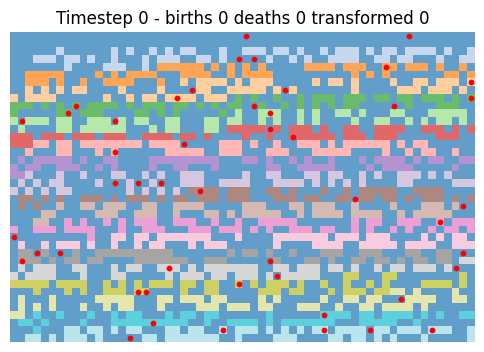

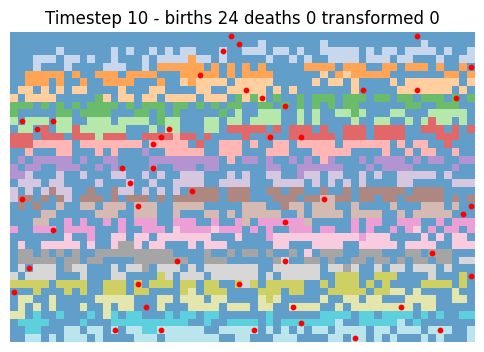

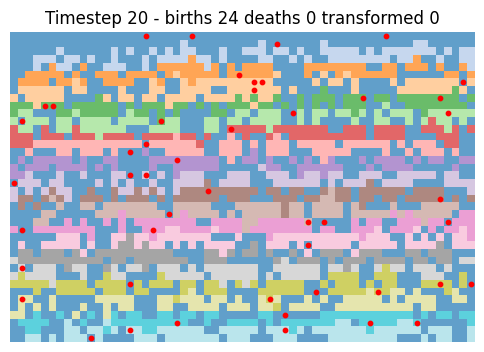

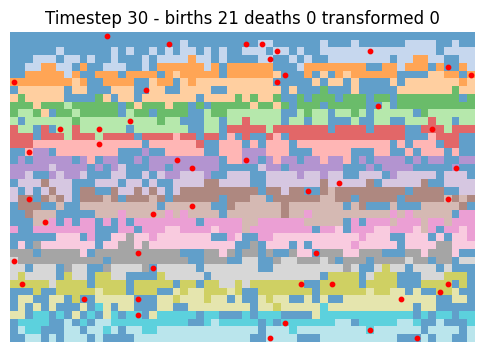

Found checkpoint abm_sweep_results_checkpoint.pkl, loading...
Resuming: 108 tasks already completed.
Total tasks: 108  Pending: 0  Completed: 108
Using 1 workers for multiprocessing
Saved aggregated results to abm_sweep_results.pkl
    initial_density  phagocyte_frac  motifs  mean_final_transformed  \
0               0.2            0.01  (0.8,)                     0.0   
1               0.2            0.01  (1.0,)                     0.0   
2               0.2            0.01  (1.2,)                     0.0   
3               0.2            0.03  (0.8,)                     0.0   
4               0.2            0.03  (1.0,)                     0.0   
5               0.2            0.03  (1.2,)                     0.0   
6               0.2            0.06  (0.8,)                     0.0   
7               0.2            0.06  (1.0,)                     0.0   
8               0.2            0.06  (1.2,)                     0.0   
9               0.5            0.01  (0.8,)               

/usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=159) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


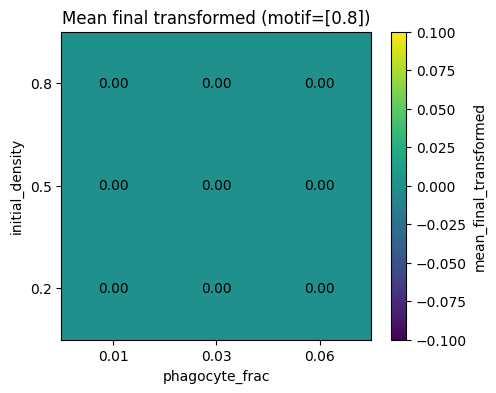

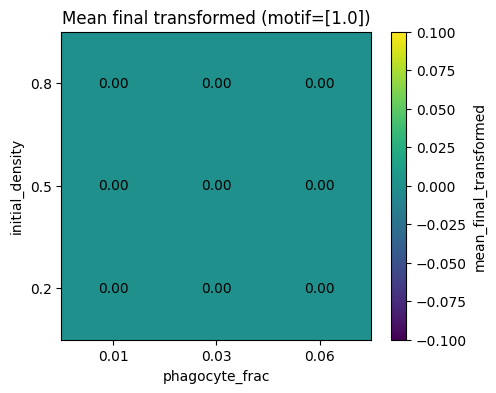

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


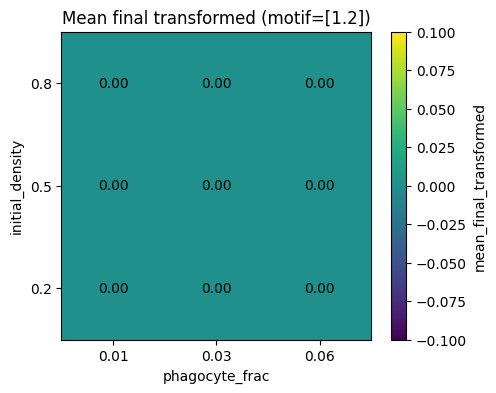

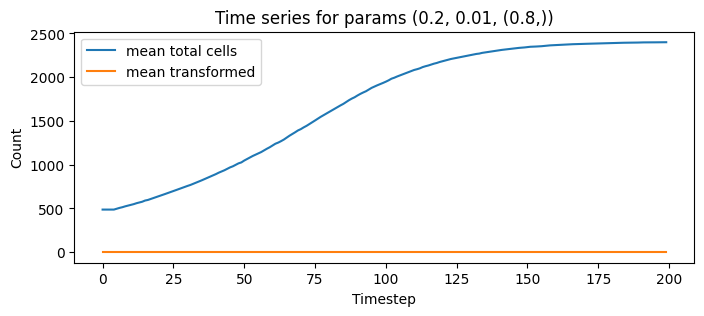

In [ ]:
# IVCSF Colab-ready simulation notebook (multi-cell agent-based extension)
# Purpose: Runnable simulation environment for a virtual cell system with
# mechanistic telomere dynamics AND an agent-based multi-cell layer (competing
# clones, immune-like phagocytes, spatial interactions). Ready for Colab.

# %% [markdown]
# # Immortal Virtual Cell Simulation Framework — Multi-cell Agent-Based Extension
#
# This file builds on the mechanistic single-cell environment and adds:
# - A 2D grid-based agent simulation where each grid cell may contain one biological cell
# - Cell behaviors: division, death (apoptosis), senescence, mutation accumulation
# - Clone labeling so you can observe clonal expansion and competition
# - Mobile phagocytes (immune-like agents) that clear debris and target apoptotic or transformed cells
# - Visualization utilities for per-step snapshots
#
# Notes:
# - Models are intentionally simplified and modular so you can replace components
#   (e.g., telomerase kinetics, repair) with higher-fidelity implementations.
# - This notebook is for computational exploration only.

# %%
!pip install --quiet stable-baselines3[extra] gym numpy matplotlib tqdm

# %%
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Reuse/define mechanistic building blocks (simplified stubs for ABM speed)
class SequenceTelomere:
    def __init__(self, repeats=180, motif_strength=1.0):
        self.repeats = repeats
        self.length_bp = 6 * repeats
        self.mutation_count = 0
        self.motif_strength = motif_strength
    def tloop_stability(self):
        return max(0.1, 0.5 + 0.01 * self.motif_strength * self.repeats - 0.005 * self.mutation_count)
    def susceptible_to_breaks(self, oxidative_stress):
        base_prob = 0.01 * oxidative_stress
        return float(np.clip(base_prob / self.tloop_stability(), 0.0, 1.0))
    def accumulate_mutation(self):
        self.mutation_count += 1
    def effective_length(self):
        return max(0.0, self.length_bp - 10.0 * self.mutation_count)

class TelomeraseKinetics:
    def __init__(self, k_cat=0.5):
        self.k_cat = k_cat
    def step(self, controller_signal, energy):
        return controller_signal * self.k_cat * 50.0  # bp-equivalent

class DNARepairModule:
    def __init__(self, hr_capacity=0.6):
        self.hr_capacity = hr_capacity
    def repair_dsb(self, dsb_count, energy):
        muts = 0
        for _ in range(int(dsb_count)):
            if random.random() > self.hr_capacity * energy:
                muts += 1
        return int(dsb_count), muts

class CellStateMinimal:
    def __init__(self, clone_id, motif_strength=1.0):
        self.tel = SequenceTelomere(repeats=180, motif_strength=motif_strength)
        self.telo_kin = TelomeraseKinetics(k_cat=0.5)
        self.repair = DNARepairModule(hr_capacity=0.6)
        self.dsb_load = 0
        self.point_mutations = 0
        self.oncogenic_mutations = 0
        self.p53_active = False
        self.senescent = False
        self.apoptotic = False
        self.clone_id = clone_id
        self.age = 0
        # simple metabolic energy
        self.energy = 1.0
    def step_damage(self, oxidative_stress):
        # small stochastic damage
        dsb = np.random.poisson(0.005 * oxidative_stress)
        ssn = np.random.poisson(0.02 * oxidative_stress)
        for _ in range(ssn):
            if random.random() < self.tel.susceptible_to_breaks(oxidative_stress):
                self.tel.accumulate_mutation(); self.point_mutations += 1
        self.dsb_load += dsb
        return ssn, dsb
    def repair_step(self):
        repaired, muts = self.repair.repair_dsb(self.dsb_load, self.energy)
        self.point_mutations += muts
        onc_hits = sum(1 for _ in range(muts) if random.random() < 0.01)
        self.oncogenic_mutations += onc_hits
        self.dsb_load = max(0, self.dsb_load - repaired)
        return repaired, muts, onc_hits
    def telomerase_action(self, controller_signal):
        bp = self.telo_kin.step(controller_signal, self.energy)
        if bp > 0 and self.tel.mutation_count>0 and random.random() < min(0.9, bp/1000.0):
            self.tel.mutation_count = max(0, self.tel.mutation_count - 1)
        return bp
    def evaluate(self):
        # determine fates
        if self.point_mutations > 200 or self.tel.effective_length() < 100:
            self.senescent = True
        if self.oncogenic_mutations >= 5 and random.random()<0.3:
            # transformed
            return 'transformed'
        if self.p53_active and random.random() < 0.5:
            self.apoptotic = True
        return 'normal'

# Agent-based grid
class ABMSpace:
    def __init__(self, width=40, height=40, initial_density=0.6):
        self.width = width; self.height = height
        self.grid = [[None for _ in range(width)] for _ in range(height)]
        self.debris = [[0.0 for _ in range(width)] for _ in range(height)]
        self.phagocytes = []  # list of (y,x) positions
        self.next_clone_id = 1
        # populate
        for y in range(height):
            for x in range(width):
                if random.random() < initial_density:
                    self.grid[y][x] = CellStateMinimal(clone_id=self._new_clone_id(), motif_strength=random.choice([0.8,1.0,1.2]))
        # add phagocytes
        for _ in range(int(0.02*width*height)):
            self.phagocytes.append((random.randrange(height), random.randrange(width)))
    def _new_clone_id(self):
        cid = self.next_clone_id; self.next_clone_id += 1; return cid
    def step(self, controller_policy=None):
        # controller_policy: function(cell, y,x)->signal
        # 1) cell actions: damage, repair, telomerase
        positions = [(y,x) for y in range(self.height) for x in range(self.width) if self.grid[y][x] is not None]
        random.shuffle(positions)
        births = []
        deaths = []
        transformed_positions = []
        for y,x in positions:
            cell = self.grid[y][x]
            # microenvironment oxidative stress depends on debris density
            oxidative = 1.0 + 0.1*self.debris[y][x]
            cell.age += 1
            ssn, dsb = cell.step_damage(oxidative)
            repaired, muts, onc = cell.repair_step()
            # compute controller signal
            if controller_policy is None:
                signal = 1.0  # baseline
            else:
                signal = controller_policy(cell,y,x)
            bp = cell.telomerase_action(signal)
            fate = cell.evaluate()
            # debris accumulation from apoptosis
            if cell.apoptotic:
                deaths.append((y,x)); self.debris[y][x] += 5.0
            elif fate == 'transformed':
                transformed_positions.append((y,x))
            else:
                # potential division if space nearby
                if cell.age>5 and random.random()<0.02:
                    ny,nx = self._find_empty_neighbor(y,x)
                    if ny is not None:
                        births.append((ny,nx,cell.clone_id))
                        cell.age = 0
        # apply births
        for ny,nx,clone in births:
            self.grid[ny][nx] = CellStateMinimal(clone_id=clone)
        # apply deaths
        for y,x in deaths:
            self.grid[y][x] = None
        # move phagocytes and clear debris/target transformed
        self._phagocyte_actions()
        return {'births':len(births),'deaths':len(deaths),'transformed':len(transformed_positions)}
    def _find_empty_neighbor(self,y,x):
        coords=[(y+dy,x+dx) for dy in (-1,0,1) for dx in (-1,0,1) if not (dx==0 and dy==0)]
        random.shuffle(coords)
        for ny,nx in coords:
            if 0<=ny<self.height and 0<=nx<self.width and self.grid[ny][nx] is None:
                return ny,nx
        return None,None
    def _phagocyte_actions(self):
        new_phagos=[]
        for (y,x) in self.phagocytes:
            # move randomly
            dy,dx = random.choice([-1,0,1]), random.choice([-1,0,1])
            ny, nx = max(0,min(self.height-1,y+dy)), max(0,min(self.width-1,x+dx))
            # clear some debris
            self.debris[ny][nx] = max(0.0, self.debris[ny][nx] - 0.5)
            # if apoptotic/transformed cell present, clear and consume
            cell = self.grid[ny][nx]
            if cell is not None and (cell.apoptotic or cell.oncogenic_mutations>3):
                self.grid[ny][nx] = None
                self.debris[ny][nx] += 1.0
            new_phagos.append((ny,nx))
        self.phagocytes = new_phagos
    def snapshot(self):
        # return arrays for visualization: clone map, debris map, phagocyte map
        clone_map = np.zeros((self.height,self.width),dtype=int)
        debris_map = np.array(self.debris)
        phago_map = np.zeros((self.height,self.width),dtype=int)
        for y in range(self.height):
            for x in range(self.width):
                c = self.grid[y][x]
                if c is not None:
                    clone_map[y,x] = c.clone_id
        for (y,x) in self.phagocytes:
            phago_map[y,x] = 1
        return clone_map, debris_map, phago_map

# Visualization utilities
def plot_snapshot(clone_map, debris_map, phago_map, title=''):
    plt.figure(figsize=(6,6))
    cmap = plt.cm.get_cmap('tab20')
    # display clones as colored points
    h,w = clone_map.shape
    plt.imshow(clone_map, cmap='tab20')
    # overlay debris as alpha
    plt.imshow(debris_map, cmap='Greys', alpha=0.3)
    # overlay phagocytes with red dots
    ys, xs = np.where(phago_map==1)
    plt.scatter(xs, ys, c='red', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Demo run
space = ABMSpace(width=60, height=40, initial_density=0.5)
for t in range(40):
    stats = space.step()
    if t%10==0:
        clone_map,debris_map,phago_map = space.snapshot()
        plot_snapshot(clone_map,debris_map,phago_map, title=f'Timestep {t} - births {stats["births"]} deaths {stats["deaths"]} transformed {stats["transformed"]}')

# End of multi-cell ABM extension

# %% [markdown]
# ## Parameter tuning and multi-replicate experiments
# This block runs parameter sweeps across initial cell density, phagocyte
# fraction, and motif_strength using multiprocessing for speed. It supports
# resumable checkpoints: intermediate results are saved to disk periodically
# so long runs can be resumed after interruption.

# %%
import itertools
import pickle
import os
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm

CHECKPOINT_FILE = 'abm_sweep_results_checkpoint.pkl'

def single_run_wrapper(params, seed_offset=0, timesteps=200):
    """Run a single replicate for given parameter tuple.
    params: (width, height, initial_density, phagocyte_frac, motifs, seed)
    Returns a dict of summary statistics and the time-series.
    """
    width, height, initial_density, phagocyte_frac, motifs, seed = params
    # Initialize space with deterministic-ish randomness using seed
    random.seed(seed); np.random.seed(seed)
    space = ABMSpace(width=width, height=height, initial_density=initial_density)
    desired_phagos = int(phagocyte_frac * width * height)
    space.phagocytes = [(random.randrange(space.height), random.randrange(space.width)) for _ in range(desired_phagos)]
    # set motif strengths
    for y in range(space.height):
        for x in range(space.width):
            c = space.grid[y][x]
            if c is not None:
                c.tel.motif_strength = random.choice(motifs)
    stats_time = {'births':[], 'deaths':[], 'transformed':[], 'total_cells':[], 'total_debris':[]}
    for t in range(timesteps):
        s = space.step()
        total_cells = sum(1 for y in range(space.height) for x in range(space.width) if space.grid[y][x] is not None)
        total_debris = sum(space.debris[y][x] for y in range(space.height) for x in range(space.width))
        stats_time['births'].append(s['births']); stats_time['deaths'].append(s['deaths']); stats_time['transformed'].append(s['transformed']); stats_time['total_cells'].append(total_cells); stats_time['total_debris'].append(total_debris)
    summary = {
        'params': (width, height, initial_density, phagocyte_frac, tuple(motifs), seed),
        'final_transformed': stats_time['transformed'][-1],
        'final_cells': stats_time['total_cells'][-1],
        'timeseries': stats_time
    }
    return summary


def run_sweep_multiproc(initial_densities=[0.2,0.5,0.8], phagocyte_fracs=[0.01,0.03,0.06], motif_strengths_list=[[0.8],[1.0],[1.2]], replicates=4, timesteps=200, width=60, height=40, checkpoint_every=10):
    # Build list of parameter combinations (each replicate has its own random seed)
    combos = list(itertools.product(initial_densities, phagocyte_fracs, motif_strengths_list))
    tasks = []
    seed_base = 10000
    for i, (dens, phago_frac, motifs) in enumerate(combos):
        for rep in range(replicates):
            seed = seed_base + i*replicates + rep
            tasks.append((width, height, dens, phago_frac, motifs, seed))

    # Load checkpoint if present
    completed = []
    results = []
    if os.path.exists(CHECKPOINT_FILE):
        print(f"Found checkpoint {CHECKPOINT_FILE}, loading...")
        with open(CHECKPOINT_FILE, 'rb') as f:
            data = pickle.load(f)
            completed = data.get('completed', [])
            results = data.get('results', [])
        print(f"Resuming: {len(completed)} tasks already completed.")

    # Filter tasks to run
    pending_tasks = [t for t in tasks if (t not in completed)]
    print(f"Total tasks: {len(tasks)}  Pending: {len(pending_tasks)}  Completed: {len(completed)}")

    # Multiprocessing pool
    n_workers = max(1, min(cpu_count()-1, 8))
    print(f"Using {n_workers} workers for multiprocessing")
    with Pool(processes=n_workers) as pool:
        # Use imap_unordered for progress reporting
        for i, res in enumerate(pool.imap_unordered(partial(single_run_wrapper, timesteps=timesteps), pending_tasks)):
            results.append(res)
            completed.append(pending_tasks[i])
            # checkpoint periodically
            if (len(completed) % checkpoint_every) == 0:
                with open(CHECKPOINT_FILE, 'wb') as f:
                    pickle.dump({'completed': completed, 'results': results}, f)
                print(f"Checkpoint saved: {len(completed)} tasks completed.")
    # final save
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump({'completed': completed, 'results': results}, f)
    return results

# %%
# Example invocation: run a modest sweep using multiprocessing (adjust replicates/timesteps as needed)
initial_densities = [0.2, 0.5, 0.8]
phagocyte_fracs = [0.01, 0.03, 0.06]
motif_strengths_list = [[0.8], [1.0], [1.2]]
replicates = 4
timesteps = 200

# Run the sweep (this will create or append to the checkpoint file)
sweep_results_list = run_sweep_multiproc(initial_densities=initial_densities, phagocyte_fracs=phagocyte_fracs, motif_strengths_list=motif_strengths_list, replicates=replicates, timesteps=timesteps, width=60, height=40, checkpoint_every=6)

# Convert results list into structured dict keyed by params for compatibility with previous analysis code
sweep_results = {}
for r in sweep_results_list:
    params = r['params'][2], r['params'][3], r['params'][4]  # (density, phago_frac, motifs)
    key = (params[0], params[1], tuple(params[2]))
    sweep_results.setdefault(key, []).append(r)

# Save a human-readable aggregated pickle
with open('abm_sweep_results.pkl', 'wb') as f:
    pickle.dump(sweep_results, f)
print('Saved aggregated results to abm_sweep_results.pkl')

# %%
# Analysis & plotting (same as before) — build a DataFrame summary
import pandas as pd
summary_rows = []
for params, runs in sweep_results.items():
    dens, phago_frac, motifs = params
    final_transformed = [run['final_transformed'] for run in runs]
    final_cells = [run['final_cells'] for run in runs]
    row = {
        'initial_density': dens,
        'phagocyte_frac': phago_frac,
        'motifs': motifs,
        'mean_final_transformed': float(np.mean(final_transformed)),
        'std_final_transformed': float(np.std(final_transformed)),
        'mean_final_cells': float(np.mean(final_cells)),
        'std_final_cells': float(np.std(final_cells))
    }
    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)
print(summary_df)

# Heatmaps and time-series plotting (re-used from previous section)
for motif in motif_strengths_list:
    pivot = summary_df[summary_df['motifs'].apply(lambda x: tuple(x)==tuple(motif))].pivot(index='initial_density', columns='phagocyte_frac', values='mean_final_transformed')
    plt.figure(figsize=(5,4))
    plt.title(f"Mean final transformed (motif={motif})")
    plt.imshow(pivot.values, origin='lower', aspect='auto')
    plt.xticks(ticks=range(len(pivot.columns)), labels=[str(c) for c in pivot.columns])
    plt.yticks(ticks=range(len(pivot.index)), labels=[str(i) for i in pivot.index])
    plt.xlabel('phagocyte_frac'); plt.ylabel('initial_density')
    for (j,i),val in np.ndenumerate(pivot.values):
        plt.text(i,j,f"{val:.2f}",ha='center',va='center',color='white' if val>np.nanmax(pivot.values)/2 else 'black')
    plt.colorbar(label='mean_final_transformed')
    plt.show()

# Example timeseries for first param key
example_key = list(sweep_results.keys())[0]
runs = sweep_results[example_key]
mean_cells = np.mean([r['timeseries']['total_cells'] for r in runs], axis=0)
mean_trans = np.mean([r['timeseries']['transformed'] for r in runs], axis=0)
plt.figure(figsize=(8,3))
plt.plot(mean_cells, label='mean total cells')
plt.plot(mean_trans, label='mean transformed')
plt.xlabel('Timestep'); plt.ylabel('Count'); plt.legend(); plt.title(f'Time series for params {example_key}')
plt.show()

# Cleanup: remove checkpoint file if you want to start fresh
# os.remove(CHECKPOINT_FILE)  # uncomment to delete checkpoint

# %% [markdown]
# ## Notes on multiprocessing and checkpoints
# * Multiprocessing uses `multiprocessing.Pool` and respects the number of CPUs available. In Colab, available CPUs are usually 2-8. Adjust `n_workers` in `run_sweep_multiproc` if you want to limit CPU usage.
# * The checkpoint file (`abm_sweep_results_checkpoint.pkl`) stores both completed task parameter tuples and their results; if you re-run the function, previously completed tasks will be skipped.
# * For very large sweeps, consider splitting tasks into batches and running them in separate Colab sessions or using cloud VMs. The checkpointing approach supports this by combining results from multiple runs (they must use the same CHECKPOINT_FILE).
# * If you want, I can also add support for saving intermediate CSV summaries or upload results to Google Drive automatically in Colab.

# %% [markdown]
# ## Advanced: concurrent.futures batching + cloud-run helper
# This section adds an alternative runner that uses `concurrent.futures.ProcessPoolExecutor` with explicit batching and a per-batch progress bar (tqdm). It also includes a small helper script you can run on multiple cloud VMs to split the full sweep into non-overlapping batches and append results to the shared checkpoint file (or upload per-batch results to Google Drive / cloud storage). Use this when your sweep is large and you want robust batching or to distribute work across machines.

# %%
from concurrent.futures import ProcessPoolExecutor, as_completed

def run_task_batch(task_list, timesteps=200):
    """Run a batch of tasks sequentially in the current process (used by cloud workers).
    task_list: list of tuples (width, height, initial_density, phagocyte_frac, motifs, seed)
    Returns list of results (same format as single_run_wrapper)."""
    results = []
    for t in task_list:
        results.append(single_run_wrapper(t, timesteps=timesteps))
    return results


def run_sweep_concurrent(initial_densities=[0.2,0.5,0.8], phagocyte_fracs=[0.01,0.03,0.06], motif_strengths_list=[[0.8],[1.0],[1.2]], replicates=4, timesteps=200, width=60, height=40, batch_size=8, max_workers=None, checkpoint_every=10):
    """High-level runner that splits the full list of tasks into batches and executes them in parallel using ProcessPoolExecutor.
    - batch_size controls how many tasks each worker handles before returning results (reduces overhead)
    - max_workers defaults to CPUs-1 if None
    - checkpoint_every controls how often completed batches are appended to checkpoint file
    """
    combos = list(itertools.product(initial_densities, phagocyte_fracs, motif_strengths_list))
    tasks = []
    seed_base = 10000
    for i, (dens, phago_frac, motifs) in enumerate(combos):
        for rep in range(replicates):
            seed = seed_base + i*replicates + rep
            tasks.append((width, height, dens, phago_frac, motifs, seed))
    # split into batches
    batches = [tasks[i:i+batch_size] for i in range(0, len(tasks), batch_size)]

    # load checkpoint
    completed_batches = []
    all_results = []
    if os.path.exists(CHECKPOINT_FILE):
        print(f"Loading existing checkpoint {CHECKPOINT_FILE}...")
        with open(CHECKPOINT_FILE,'rb') as f:
            data = pickle.load(f)
            completed = data.get('completed', [])
            prev_results = data.get('results', [])
            all_results.extend(prev_results)
            # mark completed batches by presence of all tasks in completed list
            completed_tasks_set = set(completed)
            for b in batches:
                if all(t in completed_tasks_set for t in b):
                    completed_batches.append(tuple(b))
        print(f"Found {len(completed_batches)} previously completed batches.")

    pending_batches = [b for b in batches if tuple(b) not in completed_batches]
    print(f"Total batches: {len(batches)} Pending: {len(pending_batches)}")

    if max_workers is None:
        max_workers = max(1, min(cpu_count()-1, 8))
    print(f"Using up to {max_workers} workers")

    with ProcessPoolExecutor(max_workers=max_workers) as exe:
        futures = {exe.submit(run_task_batch, batch, timesteps): batch for batch in pending_batches}
        for fut in tqdm(as_completed(futures), total=len(futures), desc='Batches'):
            batch = futures[fut]
            try:
                batch_results = fut.result()
            except Exception as e:
                print(f"Batch failed: {e}")
                continue
            # append results and mark tasks as completed
            for res in batch_results:
                all_results.append(res)
            # persist checkpoint
            completed_tasks = [r['params'] for r in all_results]
            with open(CHECKPOINT_FILE,'wb') as f:
                pickle.dump({'completed': completed_tasks, 'results': all_results}, f)
    # reorganize aggregated results into dict keyed by params
    sweep_results = {}
    for r in all_results:
        params = r['params'][2], r['params'][3], r['params'][4]
        key = (params[0], params[1], tuple(params[2]))
        sweep_results.setdefault(key, []).append(r)
    # save final aggregated
    with open('abm_sweep_results.pkl','wb') as f:
        pickle.dump(sweep_results, f)
    return sweep_results

# %% [markdown]
# ### Cloud-run helper script (bash)
# Below is a small bash helper to run a subset (batch) of tasks on a cloud VM or container. The idea is:
# 1. Generate a list of batches offline (in Python) and save them to `batches.pkl`.
# 2. Upload a batch file `batches.pkl` to cloud storage or to the VM.
# 3. On the VM, run this script with an index (which batch to process). The script executes `run_task_batch` for that batch and appends results to the shared checkpoint file or uploads them back to cloud storage.

# Example bash helper (paste into a `.sh` file on the VM):
# ```bash
# #!/usr/bin/env bash
# set -e
# BATCH_INDEX=${1:-0}
# PYTHON_SCRIPT=cloud_batch_runner.py
# python3 $PYTHON_SCRIPT $BATCH_INDEX
# ```

# Example Python `cloud_batch_runner.py` to run on a cloud VM (simple outline):
# ```python
# import sys, pickle
# from your_notebook_module import run_task_batch, CHECKPOINT_FILE
#
# batch_index = int(sys.argv[1])
# with open('batches.pkl','rb') as f:
#     batches = pickle.load(f)
# batch = batches[batch_index]
# results = run_task_batch(batch, timesteps=200)
# # append results to a local checkpoint (or upload to cloud storage)
# try:
#     with open(CHECKPOINT_FILE,'rb') as f:
#         data = pickle.load(f)
# except FileNotFoundError:
#     data = {'completed':[], 'results':[]}
# for r in results:
#     data['completed'].append(r['params'])
#     data['results'].append(r)
# with open(CHECKPOINT_FILE,'wb') as f:
#     pickle.dump(data, f)
# # optionally: upload CHECKPOINT_FILE to cloud storage here
# ```

# %% [markdown]
# ## How to use the concurrent runner
# 1. In Colab or a local machine, call `run_sweep_concurrent(...)` with your desired sweep parameters. It will split tasks into batches and run them in parallel. A checkpoint file will be created and updated during the run.
# 2. To distribute across cloud VMs, generate `batches.pkl` (list of batches) locally, upload it to each VM, and run the `cloud_batch_runner.py` on each machine with a different batch index. Each VM will append its results to `abm_sweep_results_checkpoint.pkl` (or upload to shared cloud storage).
# 3. After all batches finish, the notebook aggregates per-task results into `abm_sweep_results.pkl` and produces summary analysis/plots.

# End of advanced concurrency and cloud-run helper section